In [1]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import normalized_mutual_info_score

from tqdm.notebook import tqdm 
from math import comb, log, log10, log1p

sns.set()
sns.set_style("ticks")
# sns.set(rc={'axes.facecolor':'#1E1E1E', 'figure.facecolor':'#1E1E1E'})

import tskit
import msprime

# scale down size of default plots
sns.set_context("paper")
import matplotlib as mpl
scale = 0.8
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
mpl.rcParams.update(d)

import geneinfo as gi
gi.email('kaspermunch@birc.au.dk')

def modpath(p, parent=None, base=None, suffix=None):
    par, name = os.path.split(p)
    name_no_suffix, suf = os.path.splitext(name)
    if type(suffix) is str:
        suf = suffix
    if parent is not None:
        par = parent
    if base is not None:
        name_no_suffix = base
    new_path = os.path.join(par, name_no_suffix + suf)
    if type(suffix) is tuple:
        assert len(suffix) == 2
        new_path, nsubs = re.subn(r'{}$'.format(suffix[0]), suffix[1], new_path)
        assert nsubs == 1, nsubs
    return new_path

In [2]:
s, k, fn, N = 4, 5, 5, 7
sum([comb(f-1, s-1)*comb(N-f-1, k-s-1)/comb(N-1, k-1) for f in range(k-s, N-k+s +1 )])

1.0

In [3]:
# def pos_p_val(s, k, fn, N):
#     p = sum((f-1)*comb(N-f-1, k-s-1)/comb(N-1, k-1) for f in range(fn, N-k+s  +1 ))
#     assert 1.00000001 >= p >= 0, (p, s, k, fn, N)
#     return p

# # def neg_p_val(s, k, fn, N):
# #     p = 1 - sum(comb(f-1, s-1)*comb(N-f-1, k-s-1)/comb(N-1, k-1) for f in range(k-s, fn)) 
# #     assert 1.00000001 >= p >= 0, (p, s, k, fn, N)
# #     return p

# def neg_p_val(s, k, fn, N):
#     s, k, fn, N = k-s, k, N-fn, N
#     p = sum(comb(f-1, s-1)*comb(N-f-1, k-s-1)/comb(N-1, k-1) for f in range(fn, N-k+s  +1 ))
#     assert 1.00000001 >= p >= 0, (p, s, k, fn, N)
#     return p



def prob_descendants(s, k, fn, N):
    return comb(fn-1, s-1)*comb(N-fn-1, k-s-1)/comb(N-1, k-1)

def pos_p_val(s, k, fn, N):
    p = sum(prob_descendants(s, k, f, N) for f in range(fn, N-k+s  +1 ))
    assert 1.00000001 >= p >= 0, (p, s, k, fn, N)
    return p

def neg_p_val(s, k, fn, N):
    s, k, fn, N = k-s, k, N-fn, N
    p = sum(prob_descendants(s, k, f, N) for f in range(fn, N-k+s  +1 ))
    assert 1.00000001 >= p >= 0, (p, s, k, fn, N)
    return p


def comb_p_val(s, k, fx, kx, fn, N):
    p_value = 0
    for f1 in range(fx, kx-k+s +1):
        a = prob_descendants(s, k, f1, kx)
        for f2 in range(fn, N-k+s  +1 ):
            b = prob_descendants(kx-fx, kx, N-f2, N)
            p_value += a * b
    return p_value


# TODO:
# compute the neg_prob and pos_probs and multiply them
# to get p value, sum all combinations of more extreme pos and/or neg selection.


def get_intermediate_states(all_times, clade_times):
    clade_times_set = set(clade_times)
    k, fn = 1, 1
    intermediate_states = []
    for t in all_times:
        k += 1
        if t in clade_times_set:
            fn += 1
            if fn >= 2:
                intermediate_states.append((fn, k))
    return intermediate_states


def pvalues(k, fn, intermediate_states):
    p_values = []
    for i, (fx, kx) in enumerate(intermediate_states):
        pos_p = pos_p_val(2, k, fx, kx)
        neg_p = neg_p_val(fx, kx, fn, N)
        # p_values.append((pos_p, neg_p))
        comb_p = comb_p_val(2, k, fx, kx, fn, N)
        p_values.append((pos_p, neg_p, comb_p))
    return p_values

In [6]:
# sim_tree_seq = sim_tree_sequence()
# tree = next(sim_tree_seq.trees())
# 104 in tree.nodes()

In [11]:
# treeseq_file_name = '../data/chromhapX_tskit.trees'
# treeseq_file_name = '/Users/kmt/google_drive/projects/switch-probs/chromX_tskit.trees'
# treeseq_file_name = '../data/Eastern_Yellow_relate_chromhapX.trees'
# treeseq_file_name = '../data/Mikumi_relate_chromhapX.trees'
treeseq_file_name = '../data/Tanzania_Olive_relate_chromhapX.trees'


for treeseq_file_name in [#'../data/chromhapX_tskit.trees',
                          '../data/Mikumi_relate_chromhapX.trees',
                          '../data/Tanzania_Olive_relate_chromhapX.trees',
                          '../data/Eastern_Yellow_relate_chromhapX.trees'
                         ]:
    print(treeseq_file_name)
    
    output_file_name = modpath(treeseq_file_name, parent='../results', suffix='.h5')
    
    tree_seq = tskit.load(treeseq_file_name)
    
    
    nr_samples = tree_seq.num_samples
    
    demography = msprime.Demography()
    demography.add_population(name="pop_1", initial_size=30000)
    samples={'pop_1': nr_samples}
    
    def sim_tree_sequence(L=1_000_000, rho=1e-8, mu=1e-8, 
                          # n_subpops=1, 
                          # subpop_size=3e4, 
                          # migration_rate=1e-4
                         ):
        ts_no_mut = msprime.sim_ancestry(
            samples=nr_samples,
            demography=demography,
            # samples={f"pop_{i}": 100 for i in range(n_subpops)},  # 10 samples from each subpop
            # demography=msprime.Demography.island_model([subpop_size] * n_subpops, migration_rate),
            ploidy=1,
            recombination_rate=rho,
            sequence_length=L,
            # random_seed=123,
        )
        ts_mutated = msprime.sim_mutations(ts_no_mut, rate=mu, 
                                           # random_seed=456
                                          )
        return ts_mutated
    
    # tree_seq = sim_tree_sequence()
    # tree_seq
    
    
    # data = defaultdict(dict)
    pos_data = defaultdict(list)
    neg_data = defaultdict(list)
    comb_data = defaultdict(list)
    
    for _ in tqdm(range(100)):
        sim_tree_seq = sim_tree_sequence()
        nodes_time = sim_tree_seq.nodes_time
        for tree_idx, tree in enumerate(sim_tree_seq.trees()):
            N = tree.num_samples()
            all_times = [nodes_time[n] for n in tree.timedesc() if not tree.is_leaf(n)]
            p_values = []
            for mut in tree.mutations():
                node = sim_tree_seq.mutations_node[mut.id]
                
                clade_times = [nodes_time[n] for n in tree.timedesc(node) if not tree.is_leaf(n)]
                intermediate_states = get_intermediate_states(all_times, clade_times)
                        
                if len(intermediate_states) <= 2:
                    continue            
                two, k = intermediate_states.pop(0)
                assert two == 2
                fn, N = intermediate_states[-1]
                p_values = pvalues(k, fn, intermediate_states)
    
            if p_values:
                # pos_p_values, neg_p_values, comb_p_values = zip(*p_values)
                pos_p_values, neg_p_values, comb_p_values = zip(*p_values)
                pos_data[k].append(pos_p_values)
                neg_data[k].append(neg_p_values)
                comb_data[k].append(comb_p_values)
    
            # for i, (a, b, c) in enumerate(p_values):
            #     if i not in pos_data[k]:
            #         pos_data[k][i] = []
            #     pos_data[k][i].append(a)                
            #     if i not in neg_data[k]:
            #         neg_data[k][i] = []
            #     neg_data[k][i].append(b)
            
    
    #samples = tree_seq.num_samples
    pos_corrections = {}
    neg_corrections = {}
    comb_corrections = {}
    
    bins = np.linspace(0, 1, 100)    # CHANGE BACK TO 1000
    for k in range(3, nr_samples):
        c = 1
        for i in range(nr_samples-k):
            a, b = [], []
            for x in pos_data[k]:
                if len(x) > i+1:
                    a.append(x[i])
                    b.append(x[i+1])
            c += 1 - normalized_mutual_info_score(np.digitize(a, bins), np.digitize(b, bins))
            # print('pos', k, i, c)
            pos_corrections[(k, i+1)] = c    
        
    
        c = 1
        for i in range(nr_samples-k):
            a, b = [], []
            for x in neg_data[k]:
                if len(x) > i+1:
                    a.append(x[i])
                    b.append(x[i+1])
            c += 1 - normalized_mutual_info_score(np.digitize(a, bins), np.digitize(b, bins))
            # print('neg', k, i, c)
            neg_corrections[(k, i+1)] = c
    
        c = 1
        for i in range(nr_samples-k):
            a, b = [], []
            for x in comb_data[k]:
                if len(x) > i+1:
                    a.append(x[i])
                    b.append(x[i+1])
            c += 1 - normalized_mutual_info_score(np.digitize(a, bins), np.digitize(b, bins))
            # print('comb', k, i, c)
            comb_corrections[(k, i+1)] = c

    

    
    records = []
    nodes_time = tree_seq.nodes_time
    # for tree in tqdm(tree_seq.trees()):
    tree_idx = 0
    for tree in tqdm(tree_seq.trees()):
    
        N = tree.num_samples()
        all_times = [nodes_time[n] for n in tree.timedesc() if not tree.is_leaf(n)]
        for mut in tree.mutations():
            node = tree_seq.mutations_node[mut.id]
            clade_times = [nodes_time[n] for n in tree.timedesc(node) if not tree.is_leaf(n)]
            intermediate_states = get_intermediate_states(all_times, clade_times)
    
            if len(intermediate_states) < 4:
                continue
                
            two, k = intermediate_states.pop(0)
            assert two == 2
            if k == 2:
                continue
    
            # fn, N = intermediate_states[-1]
            fn, N = intermediate_states.pop() # TODO: check this is correct
    
            if fn / N < 0.2:
                continue
    
            p_values = pvalues(k, fn, intermediate_states)
            nr_inter = len(intermediate_states)
            
            interval = tree.interval
            num_mutations = tree.num_mutations
    

            clade_left, clade_right = interval.left, interval.right
            # shift = 1
            # while tree_idx-shift > 0 and node in tree_seq.at_index(tree_idx-shift).nodes():
            #     clade_left = tree.interval.left
            #     shift += 1 
            # shift = 1
            # while tree_idx+shift < tree_seq.num_trees and node in tree_seq.at_index(tree_idx+shift).nodes():
            #     clade_right = tree.interval.right
            #     shift += 1 
            
            
            p_p, n_p, c_p = zip(*p_values)
    
            idx = p_p.index(min(p_p))
            records.append(['pos',
                            mut.site, 
                            max(0.0, -log10((p_values[idx][0])*pos_corrections[(k, nr_inter)])), 
                            clade_times[0], 
                            clade_times[idx],
                            two,
                            k,
                            intermediate_states[idx][0],
                            intermediate_states[idx][1],
                            fn,
                            N,
                            interval.left,
                            interval.right,
                            clade_left, 
                            clade_right,
                            num_mutations])
            idx = n_p.index(min(n_p))
            records.append(['neg',
                            mut.site, 
                            max(0.0, -log10((p_values[idx][1])*neg_corrections[(k, nr_inter)])), 
                            clade_times[0], 
                            clade_times[idx],
                            two,
                            k,
                            intermediate_states[idx][0],
                            intermediate_states[idx][1],
                            fn,
                            N,
                            interval.left,
                            interval.right,
                            clade_left, 
                            clade_right,                        
                            num_mutations])
            c_idx = c_p.index(min(c_p))        
            records.append(['comb',
                            mut.site, 
                            max(0.0, -log10((p_values[idx][2])*comb_corrections[(k, nr_inter)])), 
                            clade_times[0], 
                            clade_times[idx],
                            two,
                            k,
                            intermediate_states[idx][0],
                            intermediate_states[idx][1],
                            fn,
                            N,
                            interval.left,
                            interval.right,
                            clade_left, 
                            clade_right,                        
                            num_mutations])        
    
    
        # if interval.right > 3_500_000:
        #     break
    
        tree_idx += 1
    
    
    df = pd.DataFrame.from_records(records, columns=['stat', 'site', 'p', 't1', 't2', 's', 'k', 'fx', 'kx', 'fn', 'N', 
                                                     'tree_left', 'tree_right', 'clade_left', 'clade_right', 'nr_mut'])
    df['pos'] = tree_seq.sites_position[df.site]
    df.to_hdf(output_file_name, 'df')
#    df.head()

../data/Mikumi_relate_chromhapX.trees


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/44187 [00:00<?, ?it/s]

../data/Tanzania_Olive_relate_chromhapX.trees


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/36102 [00:00<?, ?it/s]

../data/Eastern_Yellow_relate_chromhapX.trees


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59139 [00:00<?, ?it/s]

In [23]:
eastern_yellow_scan = pd.read_hdf('../results/Eastern_Yellow_relate_chromhapX.h5')
mikumi_scan = pd.read_hdf('../results/Mikumi_relate_chromhapX.h5')
tanzania_olive_scan = pd.read_hdf('../results/Tanzania_Olive_relate_chromhapX.h5')
ethiopia_live_scan = pd.read_hdf('../results/chromhapX_tskit.h5')

# idea

- add derived node ids to intermediate_states
- move through flanking trees
- see how many nodes are retained
- for each node (both derived and ancestral) not retained, compute the binomial prob of sampling derived and ancestral across the coalescence interval where it dissappears.
- continue to the next falking trees with the nodes that remain (if an internal node dissappears, all its descendants are removed)
- continue untill no nodes remain.

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

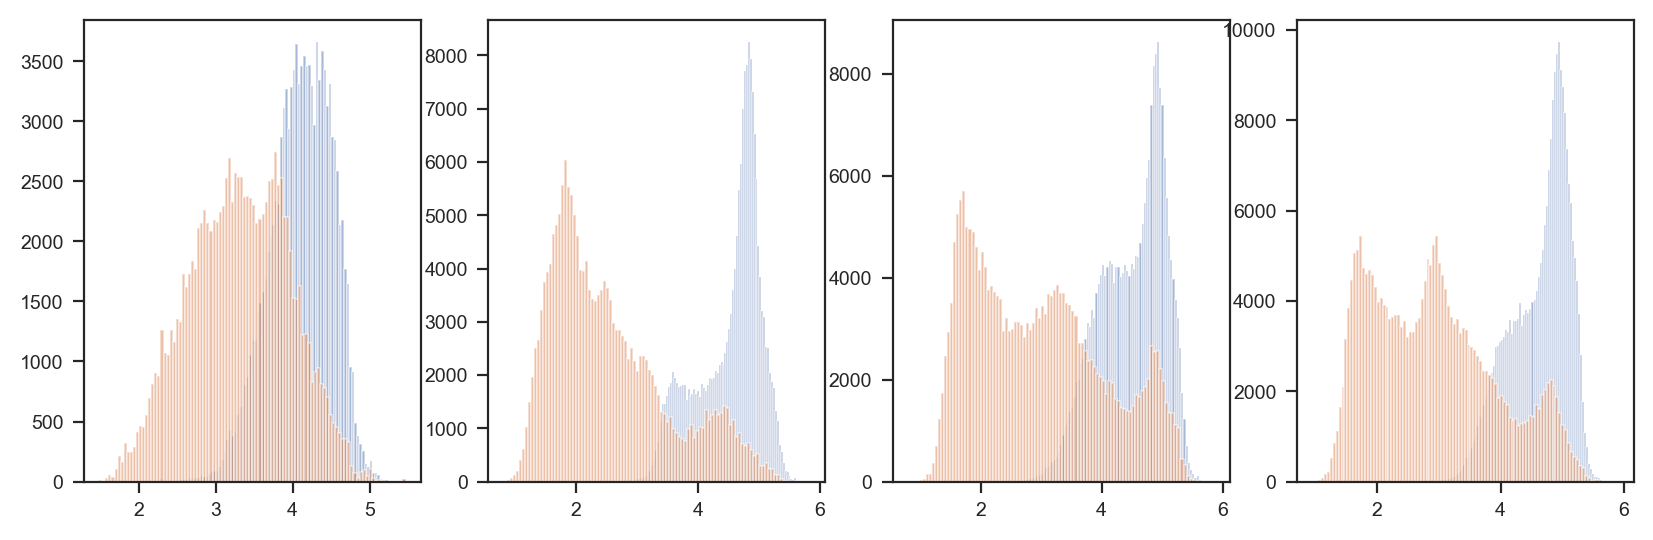

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(10,3))
for i, df in enumerate([ethiopia_live_scan, tanzania_olive_scan, mikumi_scan, eastern_yellow_scan]):
    ax[i].hist(np.log10(df.loc[df.stat == 'comb'].t1), bins=100, alpha=0.5)
    ax[i].hist(np.log10(df.loc[df.stat == 'comb'].t2), bins=100, alpha=0.5)


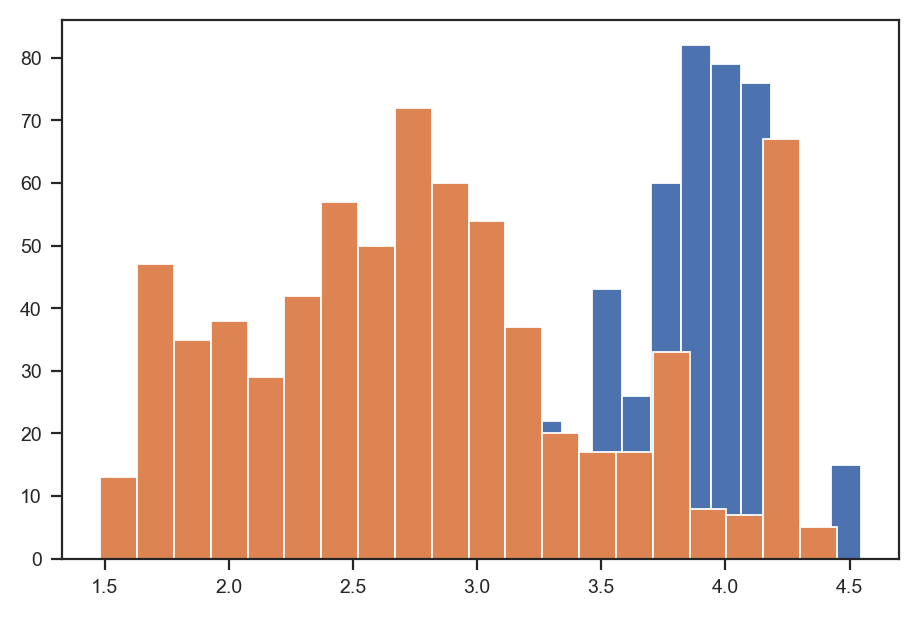

In [34]:
plt.hist(np.log10(df.loc[(df.stat == 'comb') & (df.p > 2)].t1), bins=20) ;
plt.hist(np.log10(df.loc[(df.stat == 'comb') & (df.p > 2)].t2), bins=20) ;

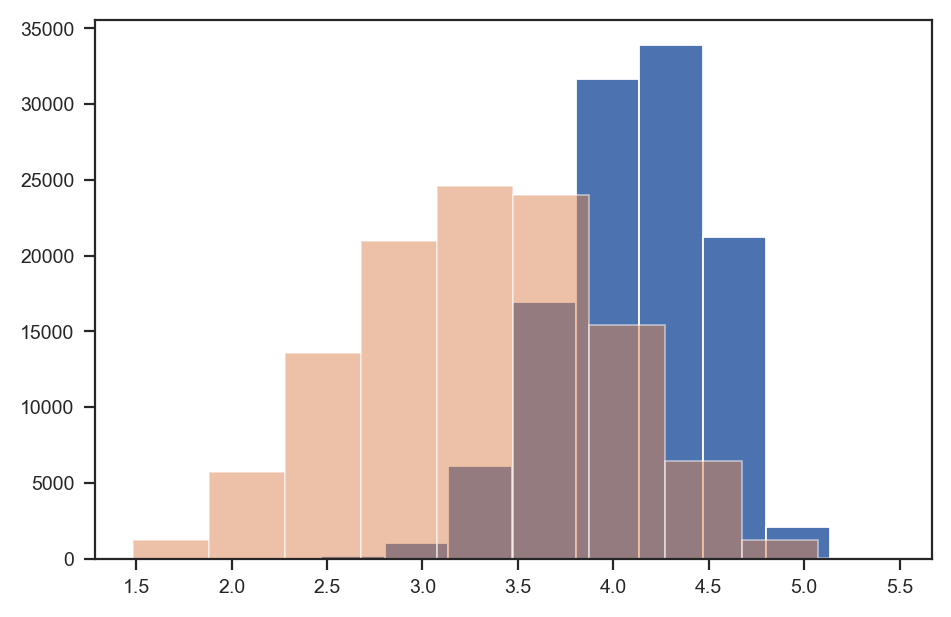

In [35]:
plt.hist(np.log10(df.loc[df.stat == 'comb'].t1)) ;
plt.hist(np.log10(df.loc[df.stat == 'comb'].t2), alpha=0.5) ;

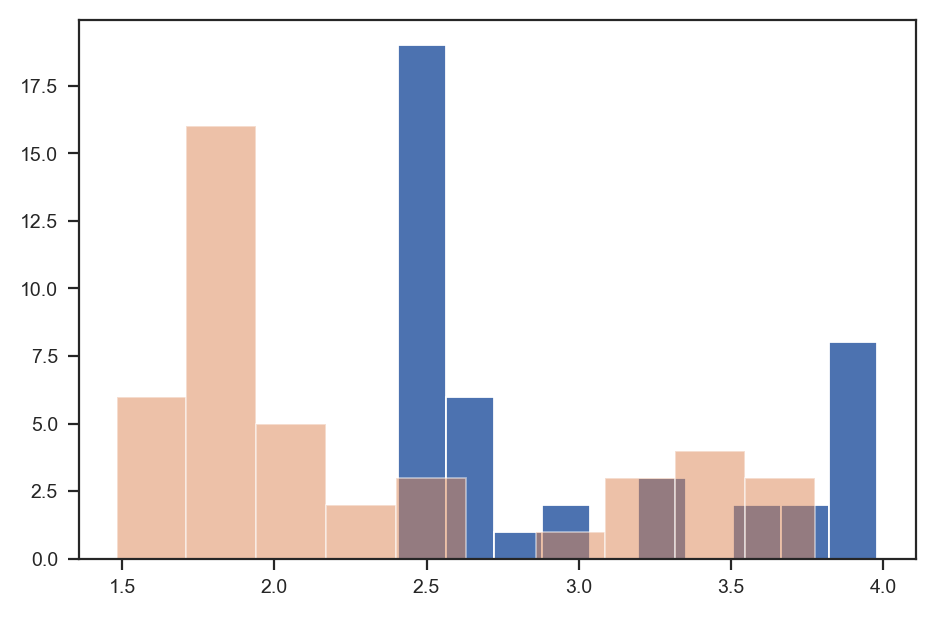

In [36]:
plt.hist(np.log10(df.loc[(df.stat == 'comb') & (df.p > 3)].t1)) ;
plt.hist(np.log10(df.loc[(df.stat == 'comb') & (df.p > 3)].t2), alpha=0.5) ;

/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_88014/845993860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['log_t1'] = np.log10(df.t1)
/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_88014/845993860.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['log_t2'] = np.log10(df.t2)


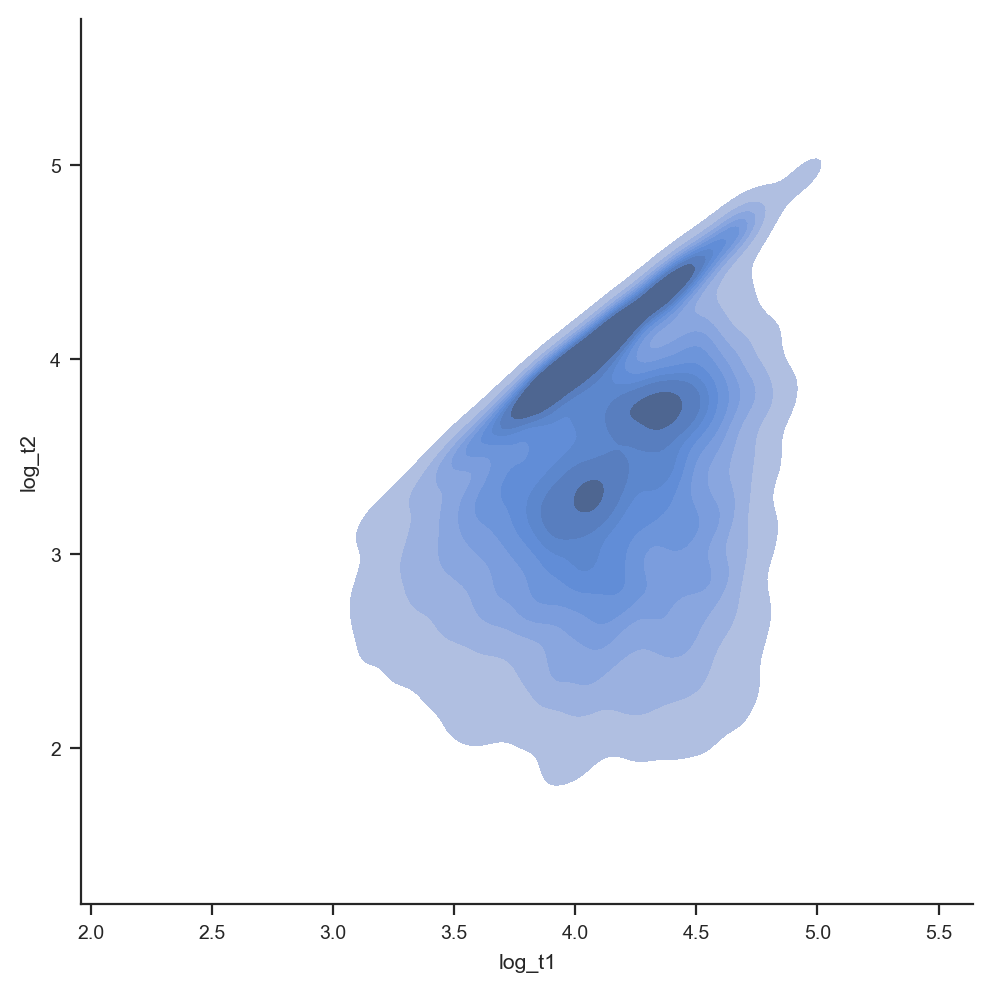

In [37]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    plot_df = df.loc[df.stat == 'comb']
    plot_df['log_t1'] = np.log10(df.t1)
    plot_df['log_t2'] = np.log10(df.t2)
    sns.displot(data=plot_df, x="log_t1", y="log_t2", kind='kde', fill=True) ;

/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_88014/3253732077.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['log_t1'] = np.log10(df.t1)
/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_88014/3253732077.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['log_t2'] = np.log10(df.t2)


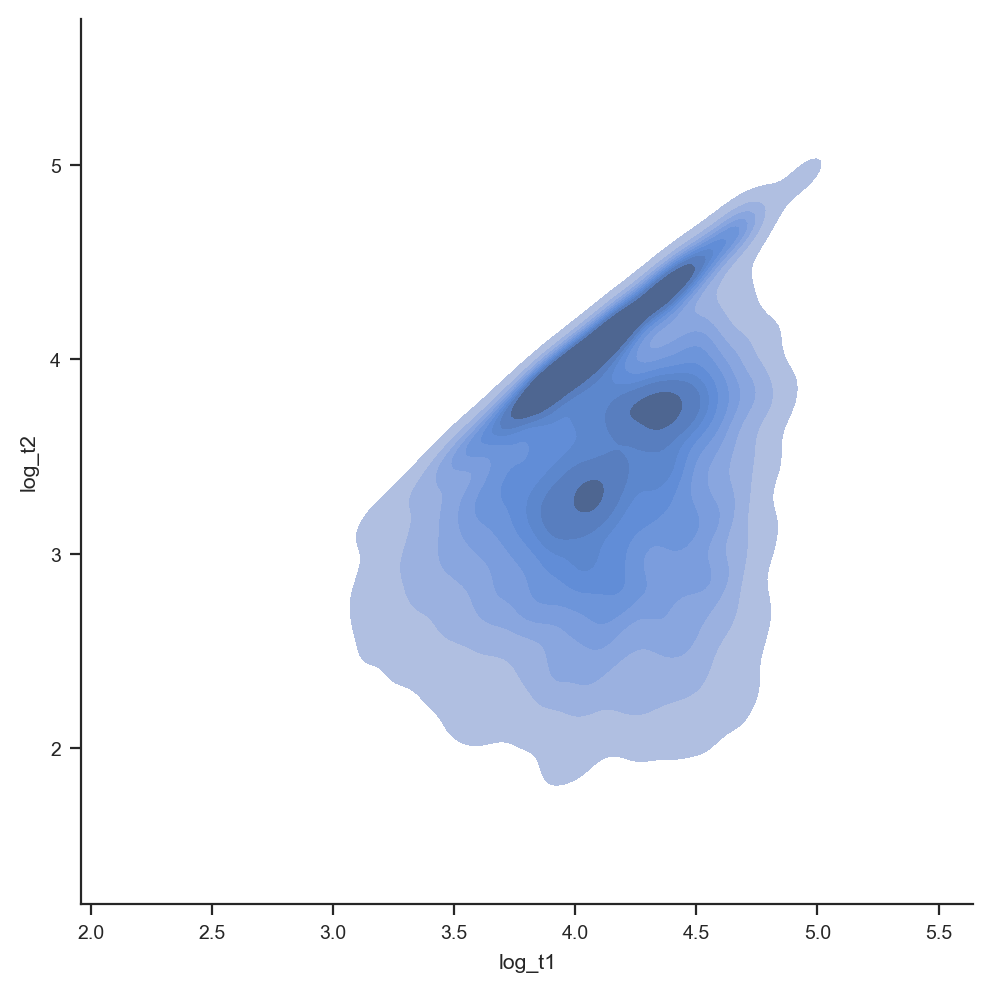

In [38]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    plot_df = df.loc[df.stat == 'comb']
    plot_df['log_t1'] = np.log10(df.t1)
    plot_df['log_t2'] = np.log10(df.t2)
    sns.displot(data=plot_df, x="log_t1", y="log_t2", kind='kde', fill=True) ;


/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_88014/2177092859.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['log_t1'] = np.log10(df.t1)
/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_88014/2177092859.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['log_t2'] = np.log10(df.t2)


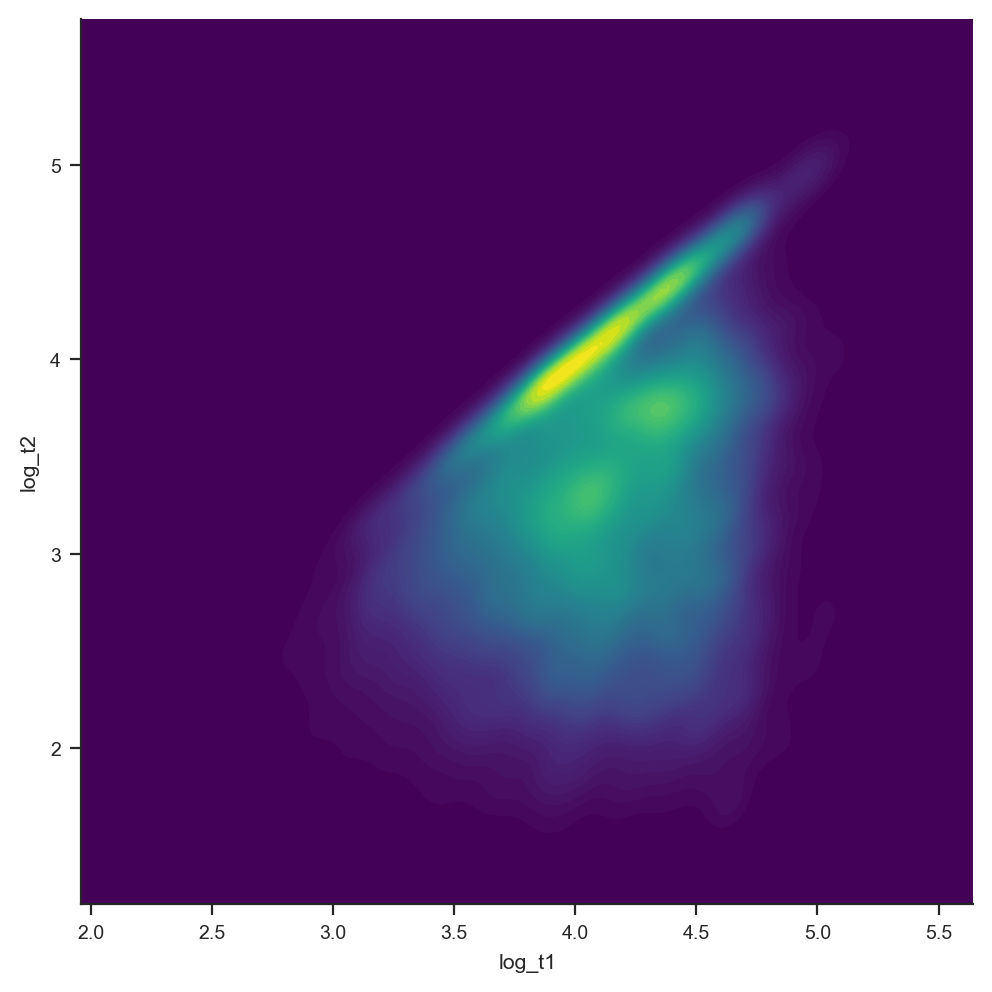

In [39]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    plot_df = df.loc[df.stat == 'comb']
    plot_df['log_t1'] = np.log10(df.t1)
    plot_df['log_t2'] = np.log10(df.t2)
    sns.displot(data=plot_df, x="log_t1", y="log_t2", kind='kde', fill=True, thresh=0, levels=100, cmap="viridis") ;


/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_88014/208622899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['log_t1'] = np.log10(df.t1)
/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_88014/208622899.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['log_t2'] = np.log10(df.t2)


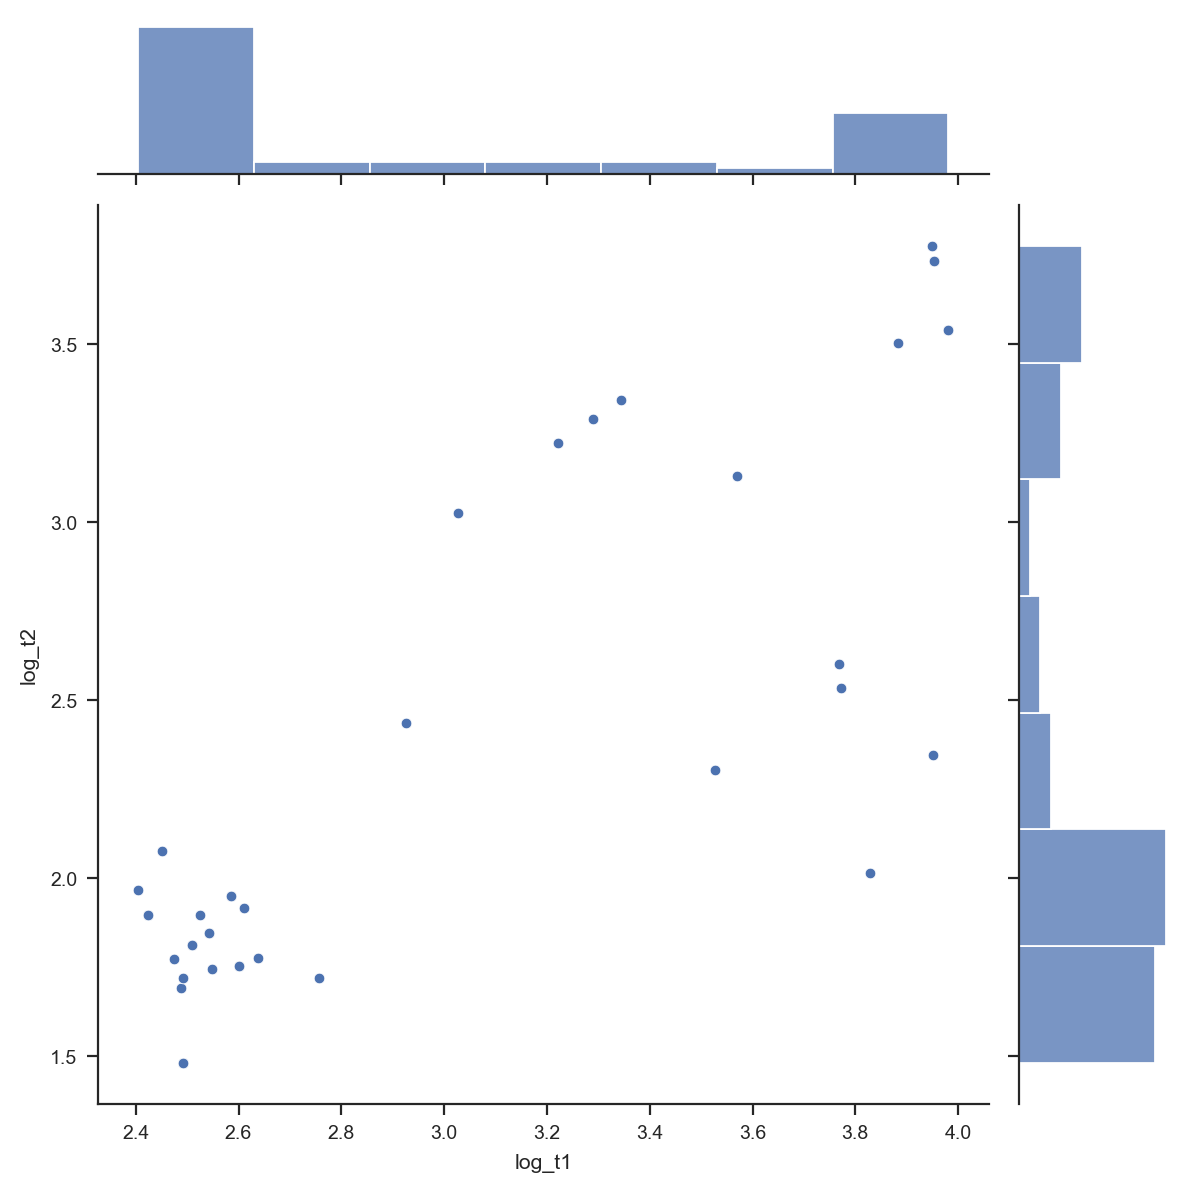

In [40]:
plot_df = df.loc[(df.stat == 'comb') & (df.p > 3)]
plot_df['log_t1'] = np.log10(df.t1)
plot_df['log_t2'] = np.log10(df.t2)
sns.jointplot(data=plot_df, x="log_t1", y="log_t2") ;

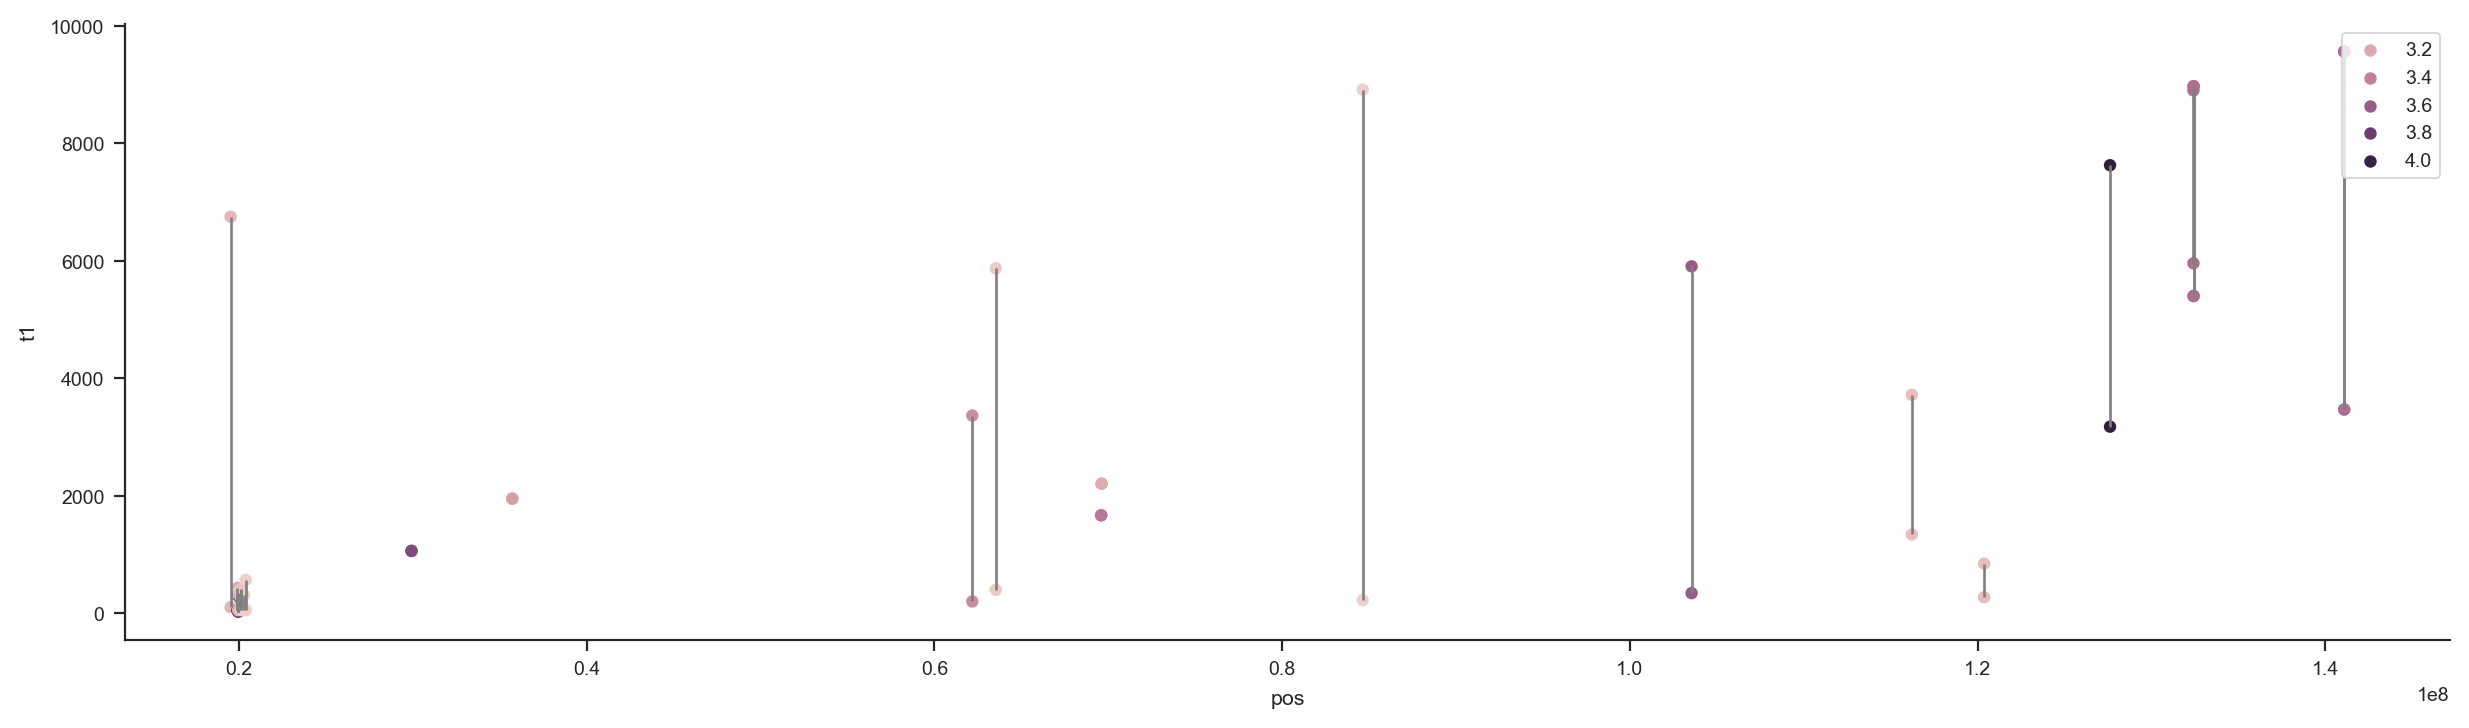

In [41]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    plot_df = df.loc[(df.stat == 'comb') & (df.p > 3)]
    
    fig, ax = plt.subplots(1, 1, figsize=(15,4))
    sns.scatterplot(data=plot_df, x='pos', y='t1', hue='p', ax=ax, linewidth=0, s=20) ;
    sns.scatterplot(data=plot_df, x='pos', y='t2', hue='p', ax=ax, linewidth=0, s=20, legend=False) ;
    ax.vlines(plot_df.pos, ymin=plot_df.t1, ymax=plot_df.t2, color='gray')
    ax.legend(loc='upper right')
    # ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
    sns.despine()
    # plt.xlim((15000000, 25000000))

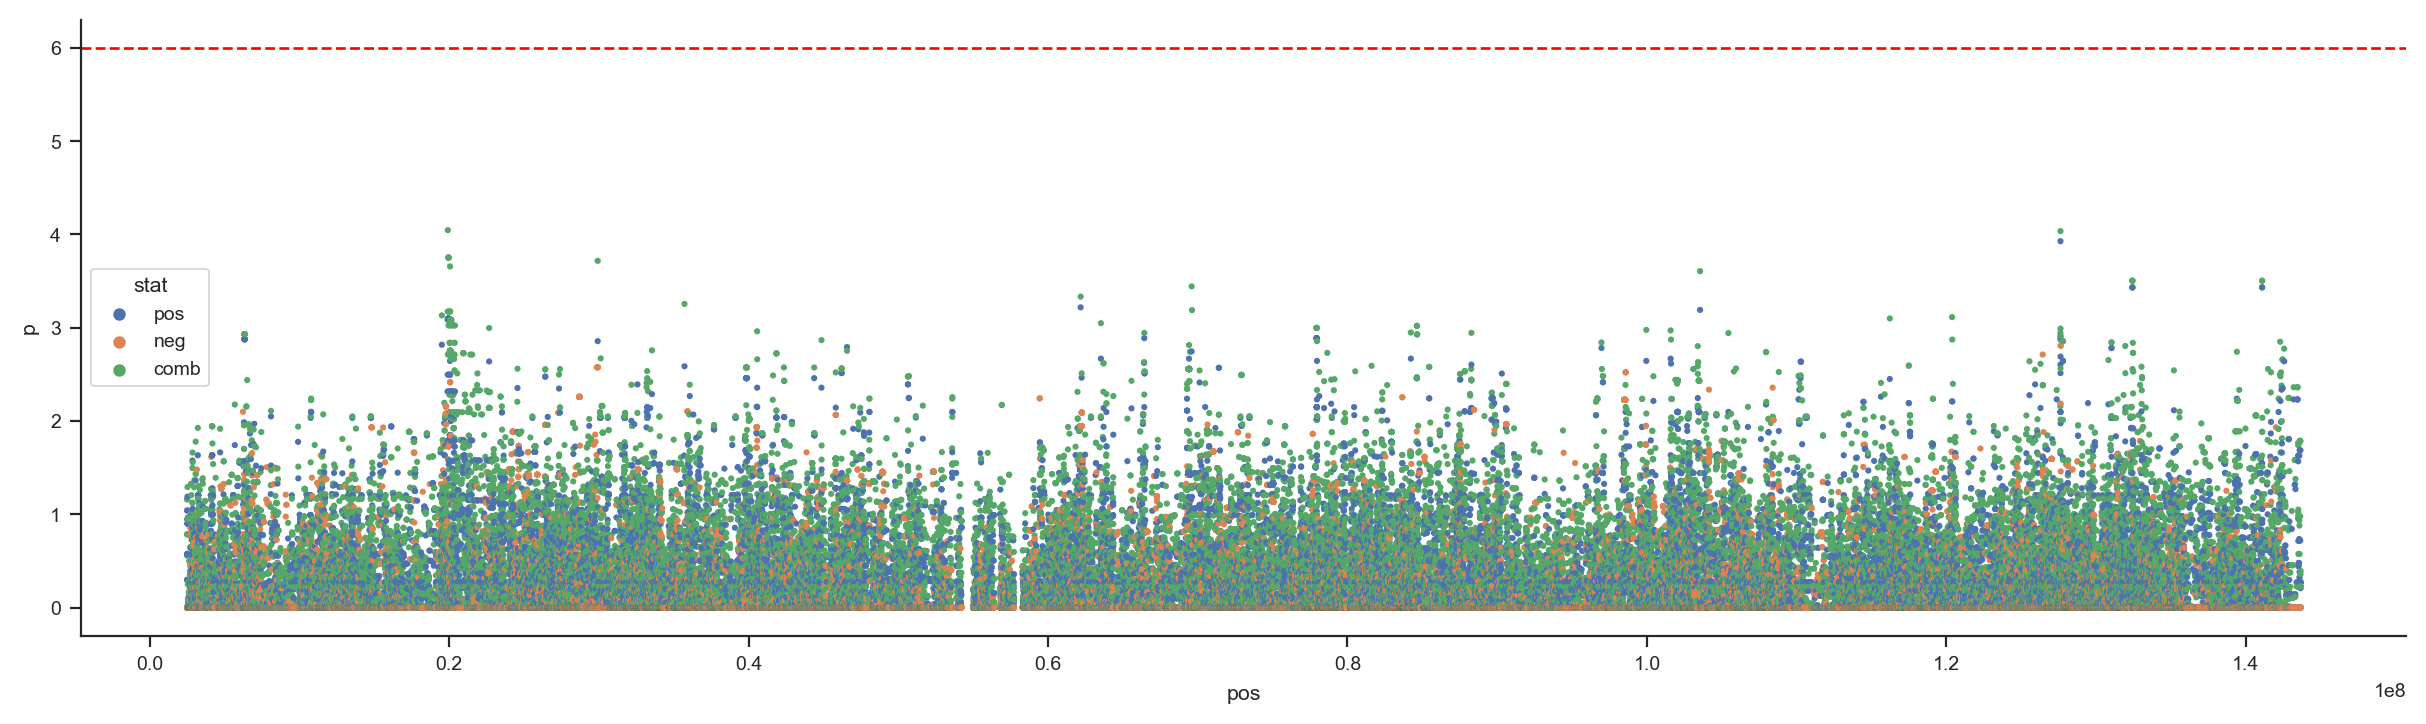

In [42]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,4))
    sns.scatterplot(data=df, x='pos', y='p', hue='stat', ax=ax, linewidth=0, s=5) ;
    # ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
    ax.axhline(-np.log10(5e-8*3100/156), color='red', linestyle='dashed') ;
    sns.despine()
    # plt.xlim((15000000, 25000000))

/Users/kmt/miniconda3/envs/tree-stats/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/kmt/miniconda3/envs/tree-stats/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


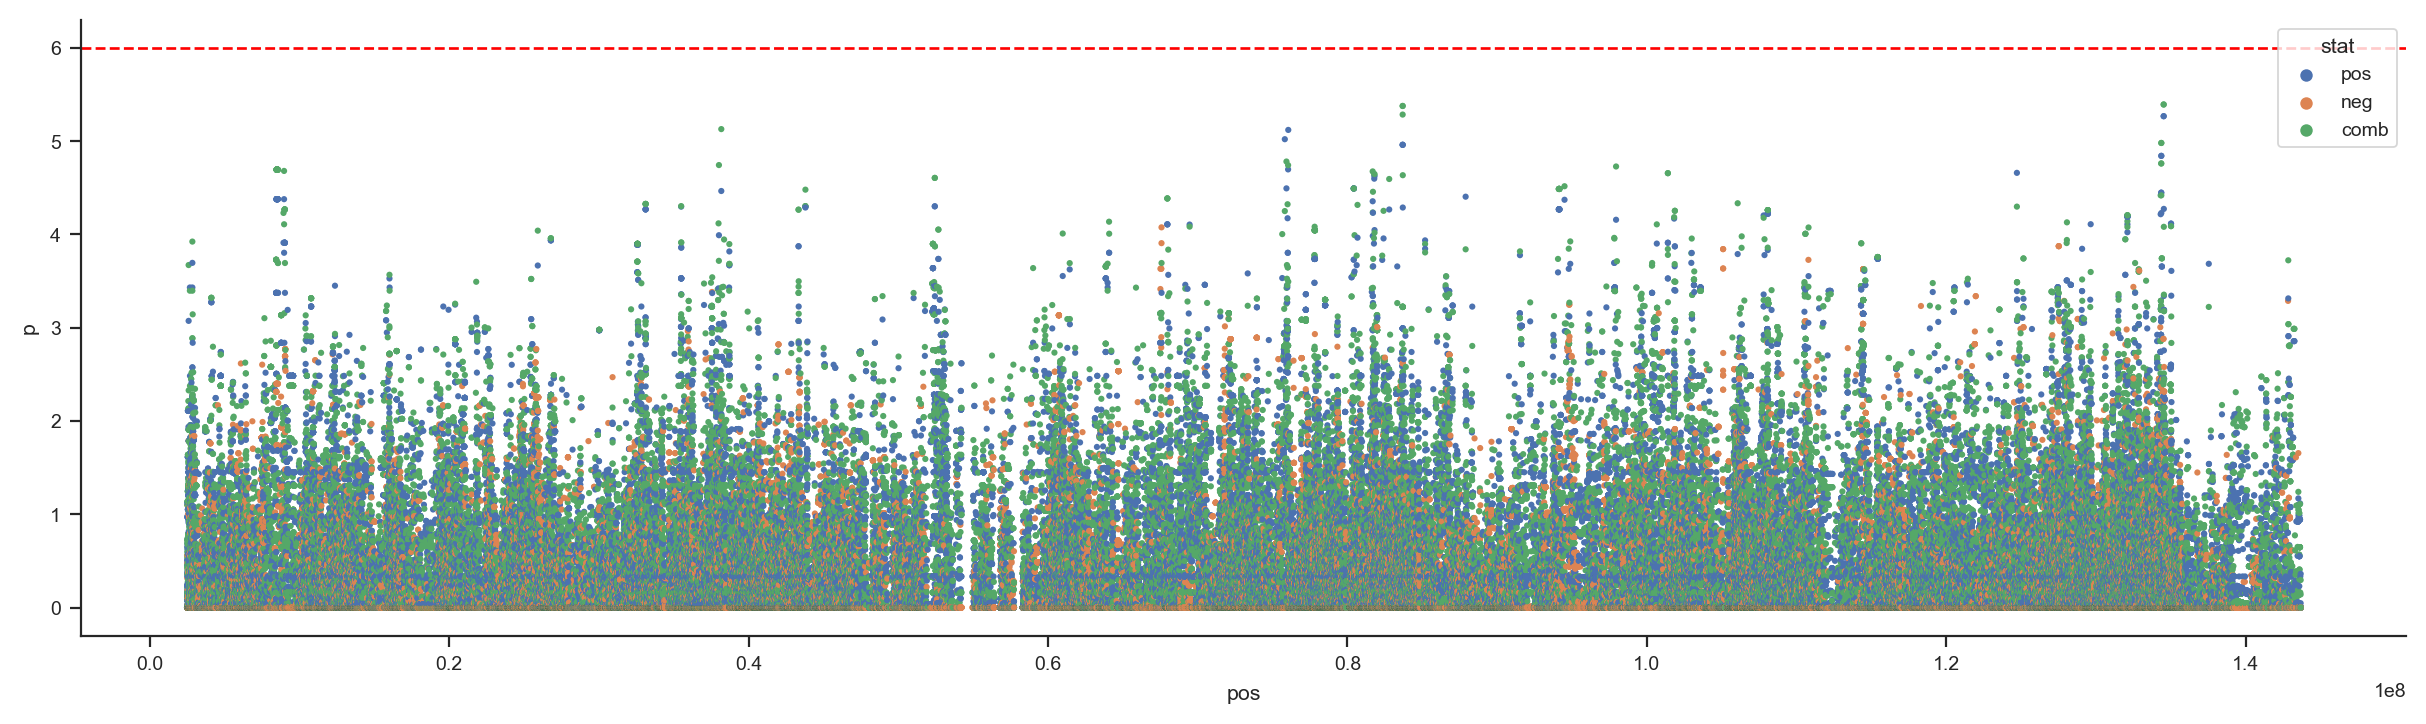

In [19]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,4))
    sns.scatterplot(data=df, x='pos', y='p', hue='stat', ax=ax, linewidth=0, s=5) ;
    # ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
    ax.axhline(-np.log10(5e-8*3100/156), color='red', linestyle='dashed') ;
    sns.despine()
    # plt.xlim((15000000, 25000000))

/Users/kmt/miniconda3/envs/tree-stats/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/kmt/miniconda3/envs/tree-stats/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


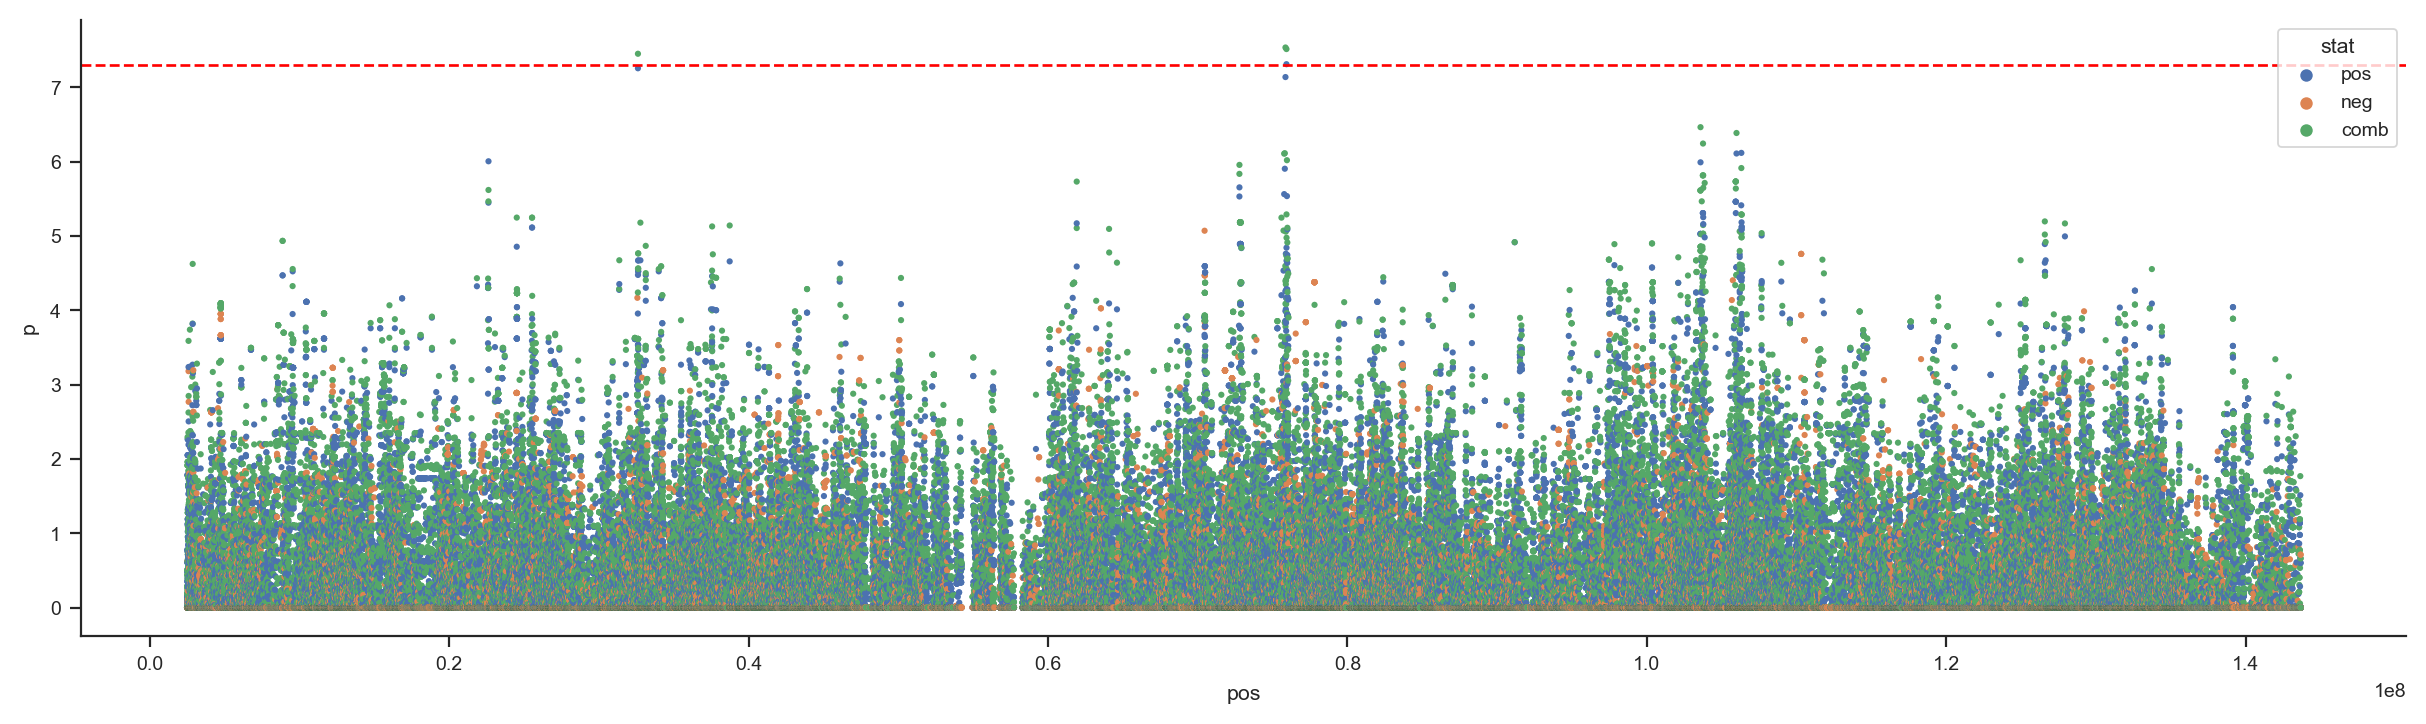

In [40]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,4))
    sns.scatterplot(data=df, x='pos', y='p', hue='stat', ax=ax, linewidth=0, s=5) ;
    # ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
    ax.axhline(-np.log10(5e-8), color='red', linestyle='dashed') ;
    sns.despine()
    # plt.xlim((15000000, 25000000))

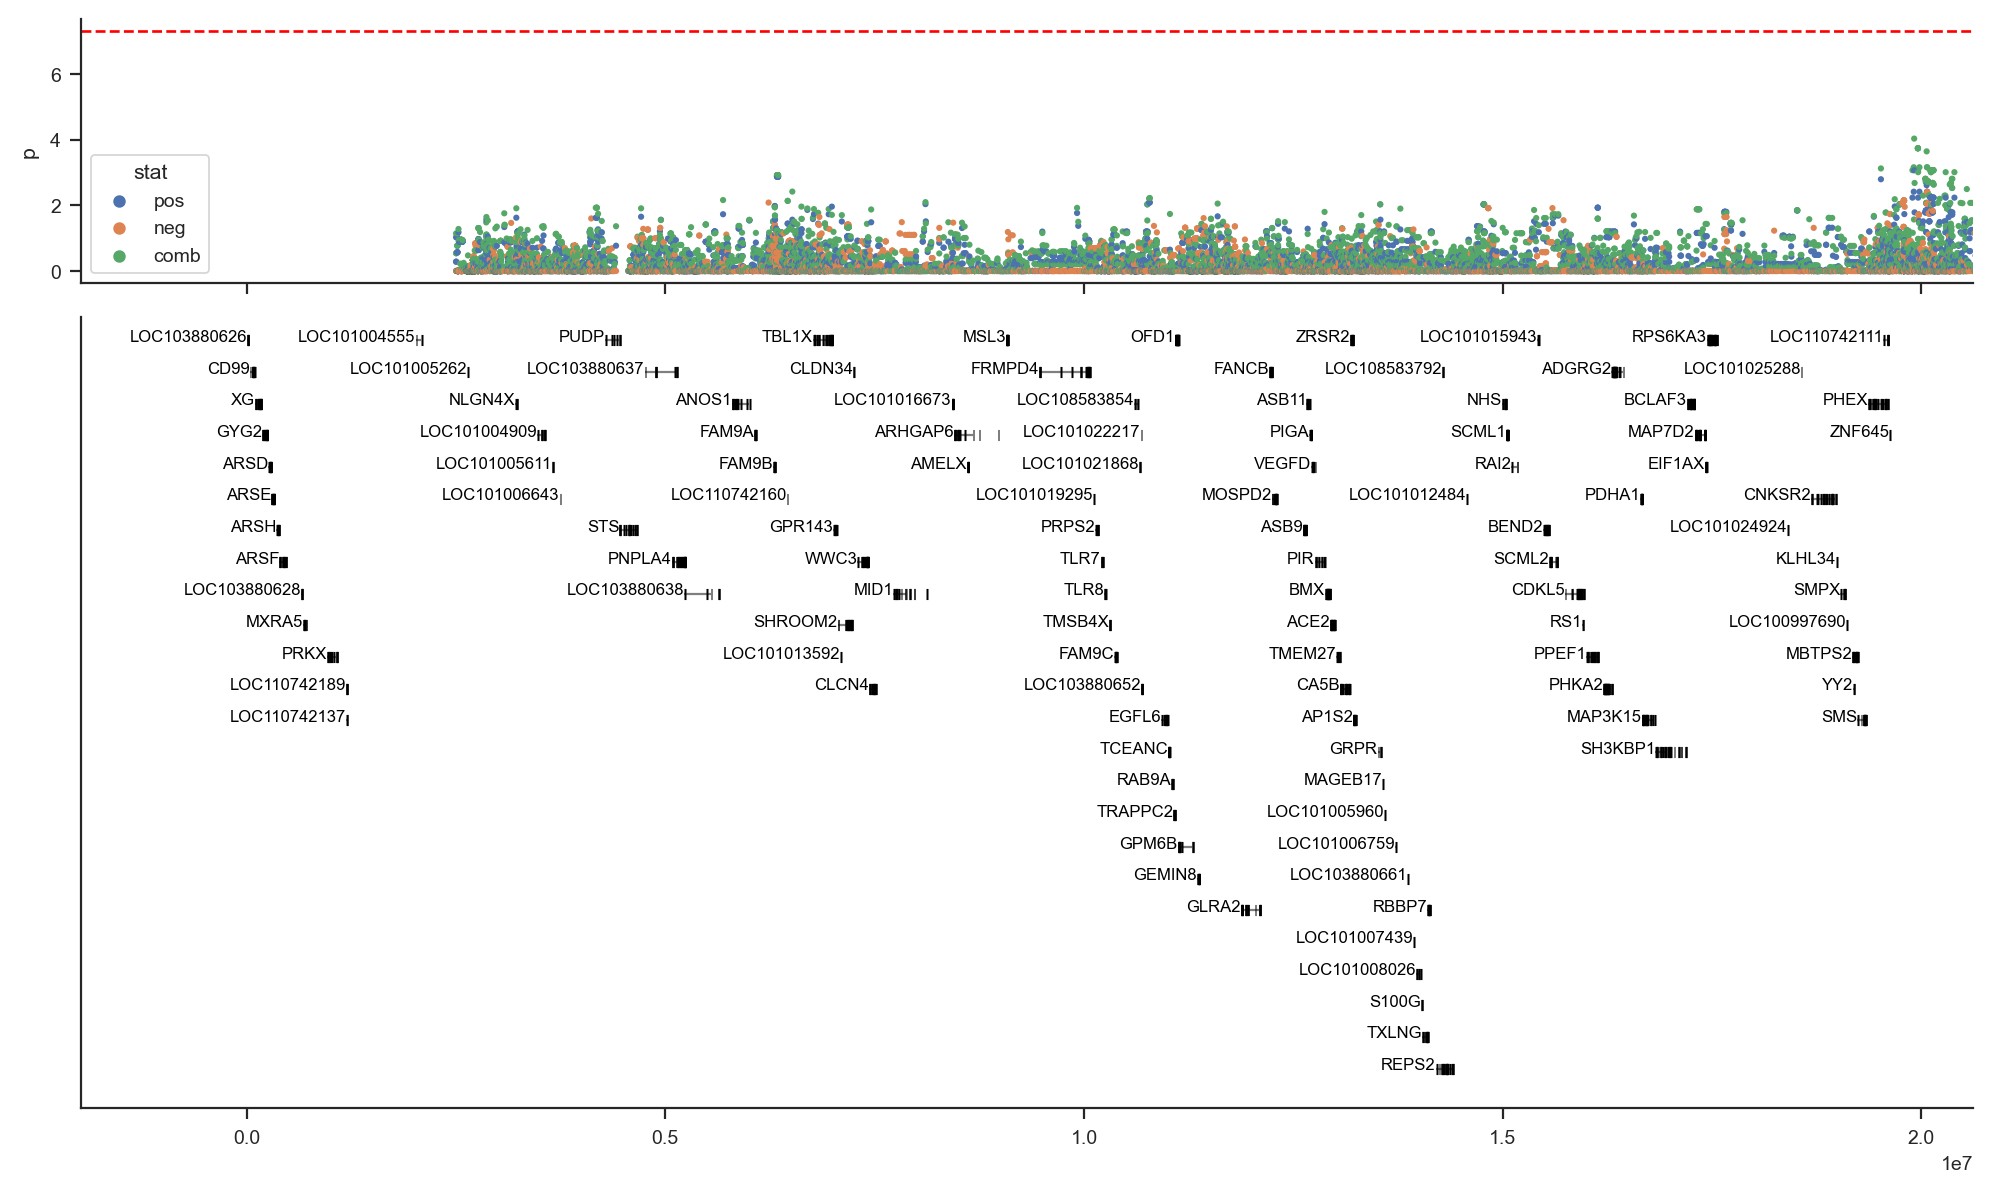

In [6]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    ax = gi.gene_plot('chrX', 0, 20_000_000, 'papAnu4', figsize=(10,6), aspect=3)
    sns.scatterplot(data=df, x='pos', y='p', hue='stat', ax=ax, linewidth=0, s=5) ;
    # ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
    ax.axhline(-np.log10(5e-8), color='red', linestyle='dashed') ;

    plt.tight_layout()
    sns.despine()

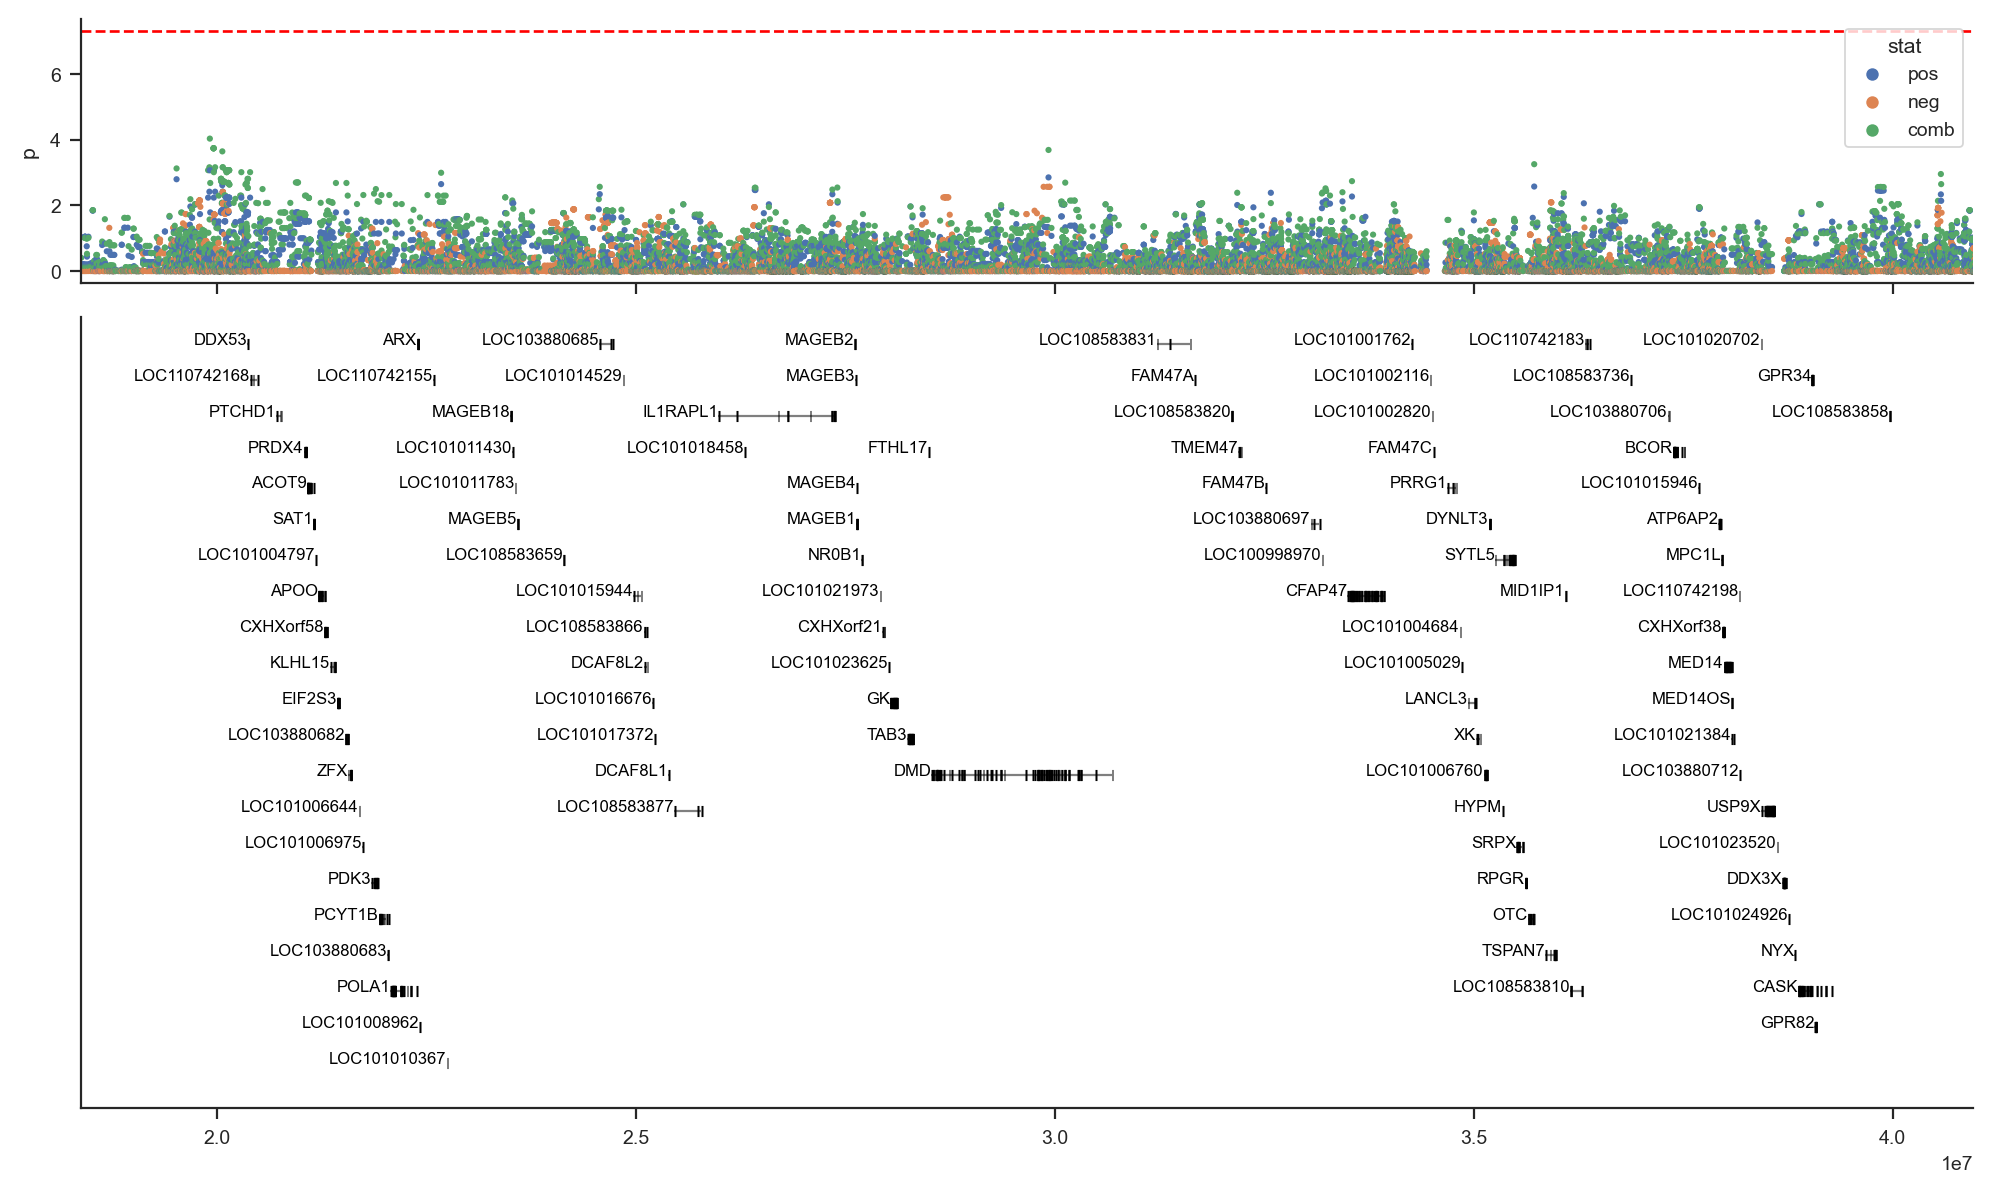

In [7]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    ax = gi.gene_plot('chrX', 20_000_000, 40_000_000, 'papAnu4', figsize=(10,6), aspect=3)
    sns.scatterplot(data=df, x='pos', y='p', hue='stat', ax=ax, linewidth=0, s=5) ;
    # ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
    ax.axhline(-np.log10(5e-8), color='red', linestyle='dashed') ;

    plt.tight_layout()
    sns.despine()

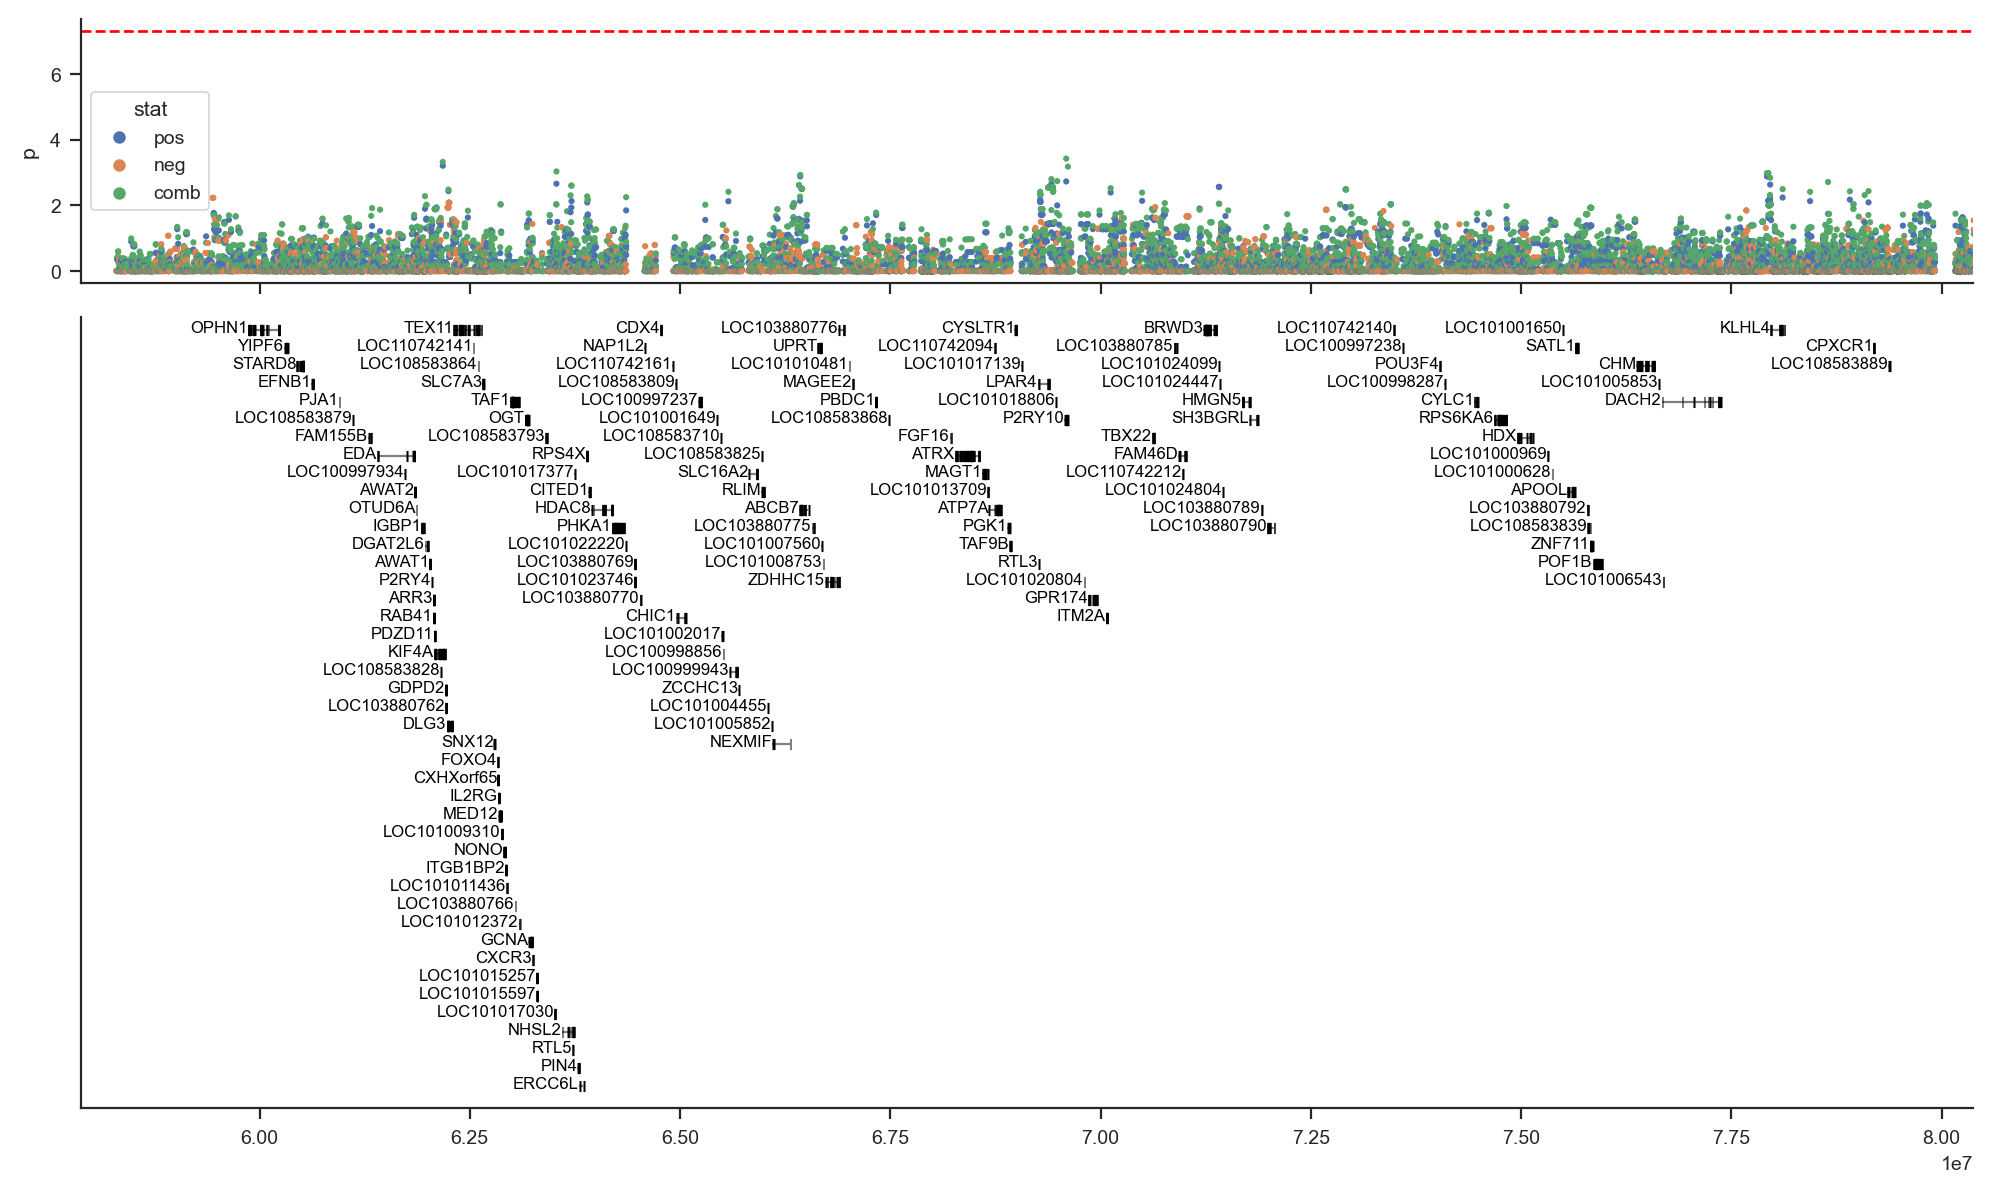

In [8]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    ax = gi.gene_plot('chrX', 60_000_000, 80_000_000, 'papAnu4', figsize=(10,6), aspect=3)
    sns.scatterplot(data=df, x='pos', y='p', hue='stat', ax=ax, linewidth=0, s=5) ;
    # ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
    ax.axhline(-np.log10(5e-8), color='red', linestyle='dashed') ;

    plt.tight_layout()
    sns.despine()

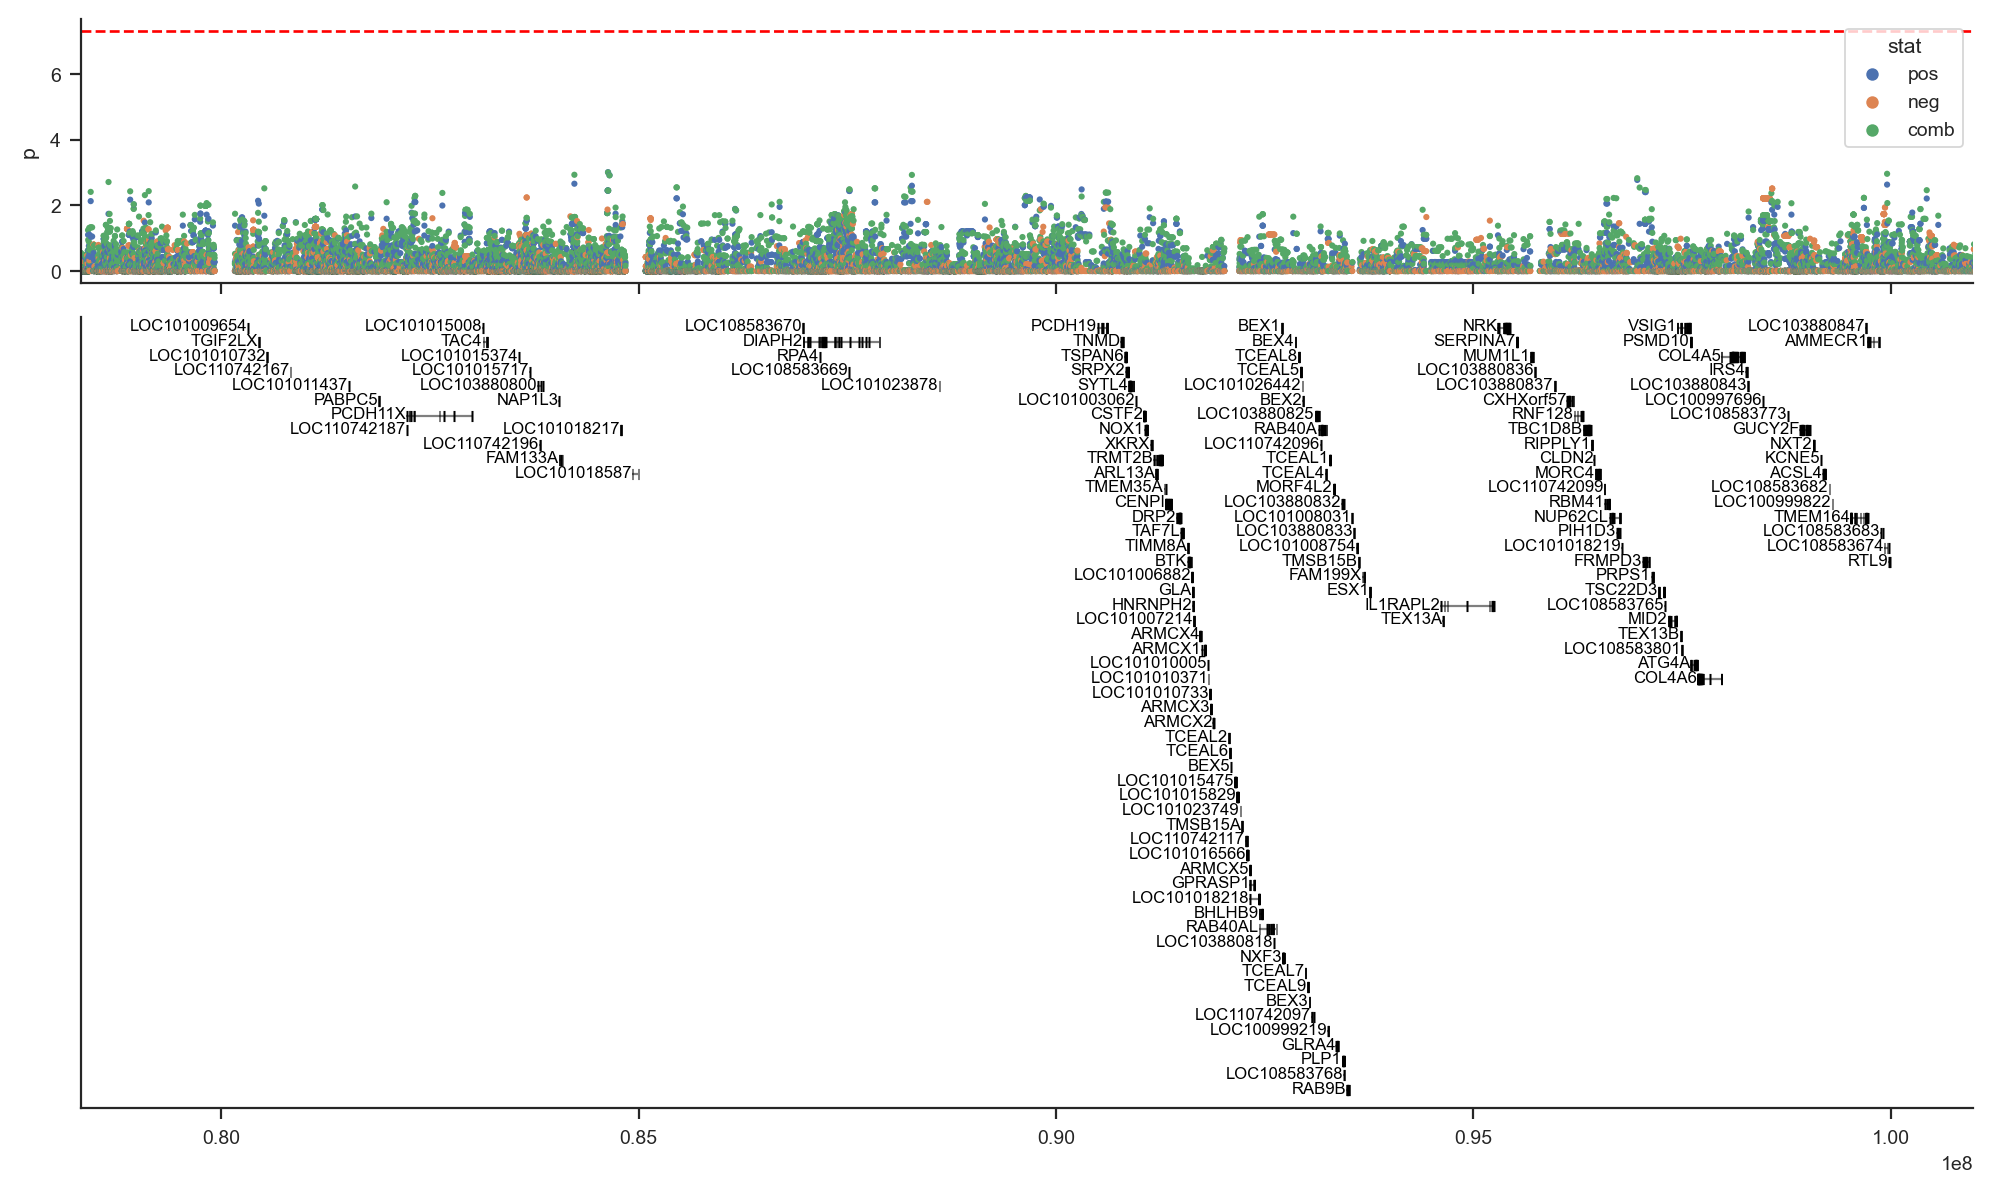

In [9]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    ax = gi.gene_plot('chrX', 80_000_000, 100_000_000, 'papAnu4', figsize=(10,6), aspect=3)
    sns.scatterplot(data=df, x='pos', y='p', hue='stat', ax=ax, linewidth=0, s=5) ;
    # ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
    ax.axhline(-np.log10(5e-8), color='red', linestyle='dashed') ;

    plt.tight_layout()
    sns.despine()

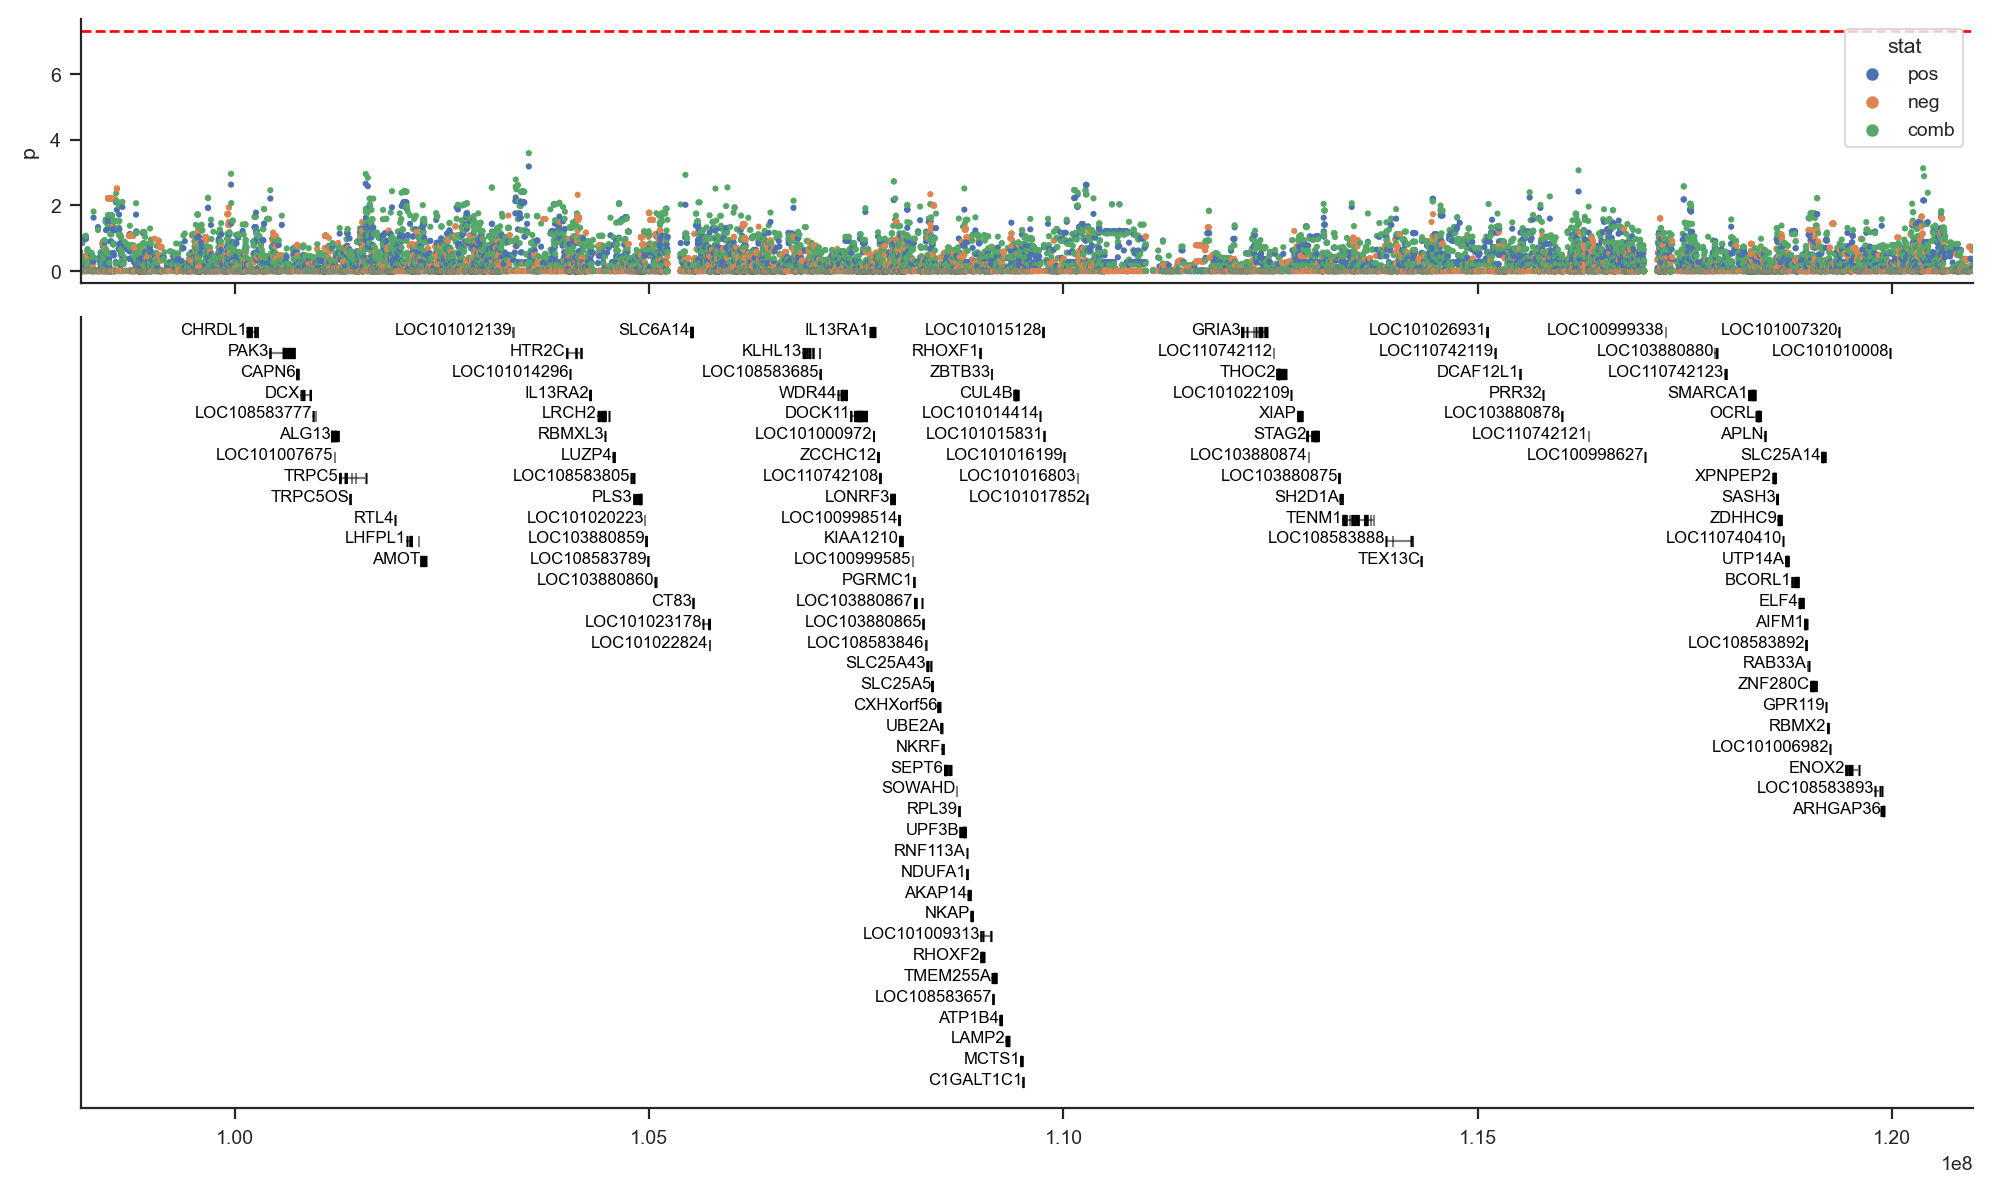

In [10]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    ax = gi.gene_plot('chrX', 100_000_000, 120_000_000, 'papAnu4', figsize=(10,6), aspect=3)
    sns.scatterplot(data=df, x='pos', y='p', hue='stat', ax=ax, linewidth=0, s=5) ;
    # ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
    ax.axhline(-np.log10(5e-8), color='red', linestyle='dashed') ;

    plt.tight_layout()
    sns.despine()

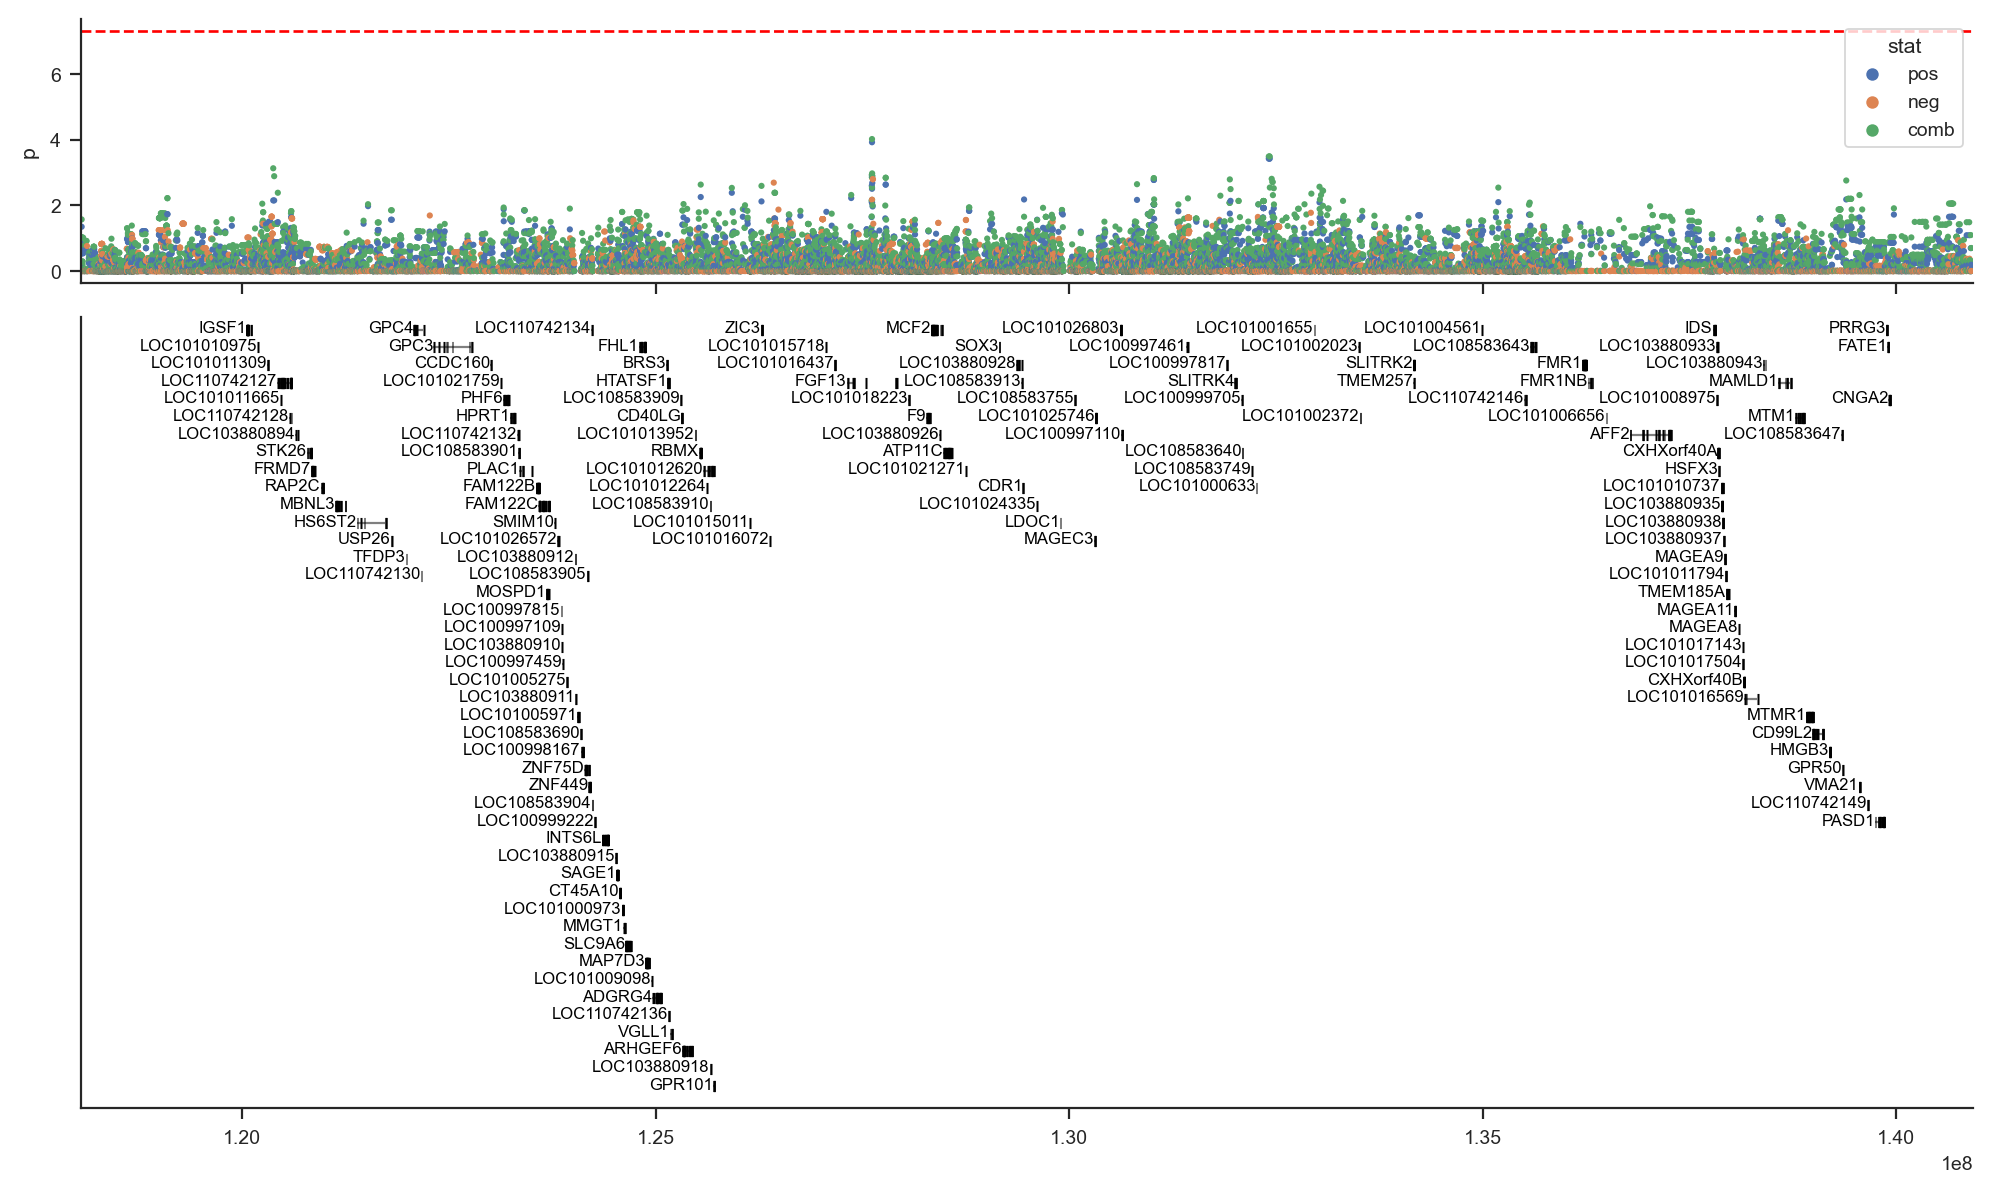

In [11]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    ax = gi.gene_plot('chrX', 120_000_000, 140_000_000, 'papAnu4', figsize=(10,6), aspect=3)
    sns.scatterplot(data=df, x='pos', y='p', hue='stat', ax=ax, linewidth=0, s=5) ;
    # ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
    ax.axhline(-np.log10(5e-8), color='red', linestyle='dashed') ;

    plt.tight_layout()
    sns.despine()

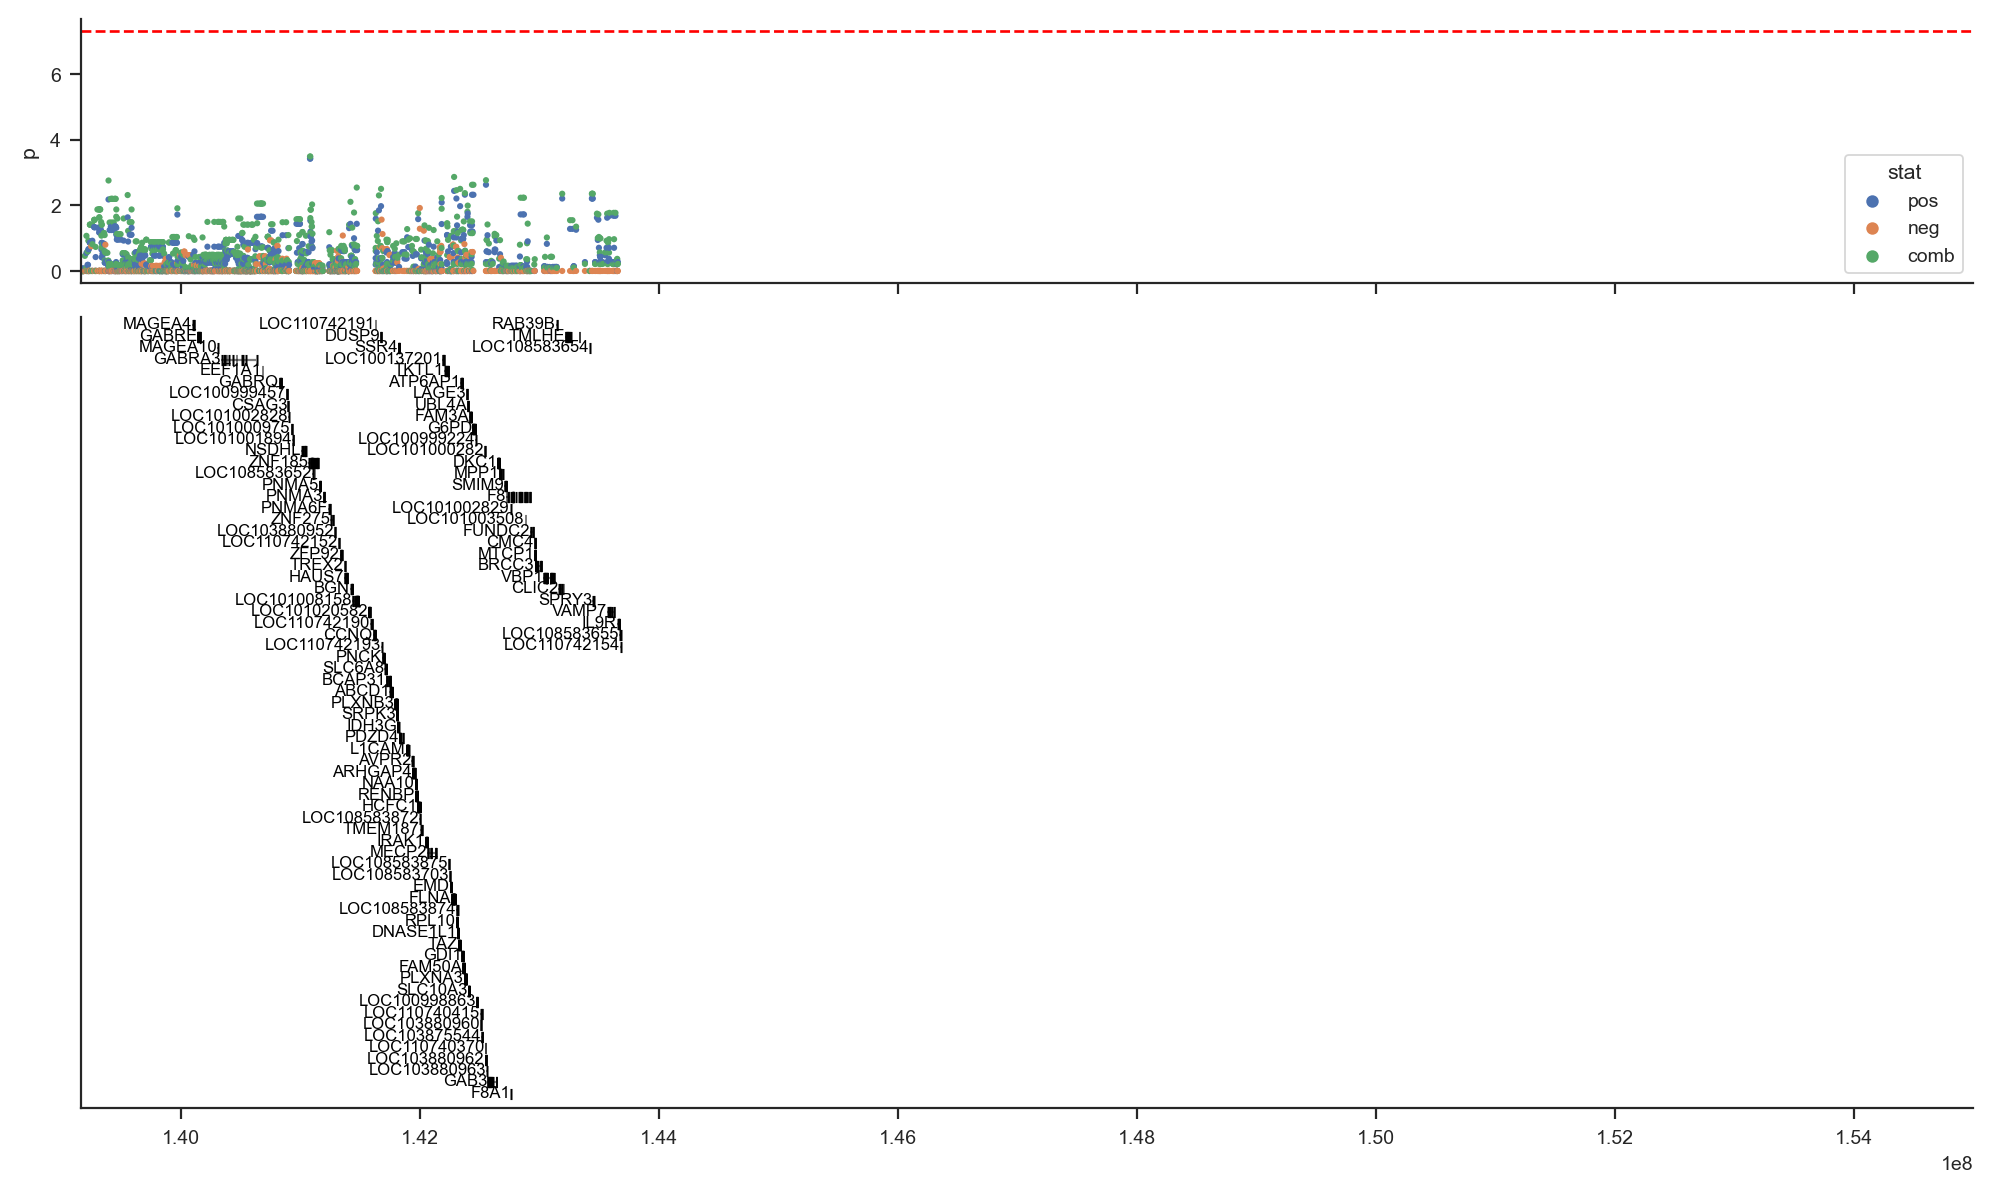

In [12]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    ax = gi.gene_plot('chrX', 140_000_000, 155_000_000, 'papAnu4', figsize=(10,6), aspect=3)
    sns.scatterplot(data=df, x='pos', y='p', hue='stat', ax=ax, linewidth=0, s=5) ;
    # ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
    ax.axhline(-np.log10(5e-8), color='red', linestyle='dashed') ;

    plt.tight_layout()
    sns.despine()